In [1]:
from fun_clean import cleaning, cleaning_sub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

In [2]:
data = pd.read_csv('airbnb_data.csv')

In [3]:
data = cleaning(data)

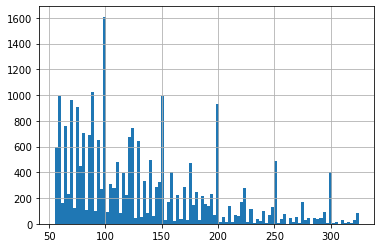

In [4]:
data.price.sort_values(ascending=False).hist(bins = 100)

In [5]:
data

,room_type,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,...,Chicago,DC,LA,NYC,SF,delta_first,delta_last,delta_host,verified,instant
0,1.000000,7,1.0,1.0,40.766115,-73.989040,6,93.0,10019,3.0,...,0,0,0,1,0,2.345379,2.211222,2.474061,0,1
1,0.413769,2,1.0,1.0,37.753164,-122.429526,3,100.0,94131,1.0,...,0,0,0,0,1,2.285145,2.260504,2.506916,1,1
2,1.000000,2,1.0,1.0,34.046737,-118.260439,9,93.0,90015,1.0,...,0,0,1,0,0,2.980574,2.660239,6.561756,1,0
3,0.413769,2,1.0,1.0,37.781128,-122.501095,159,99.0,94121,1.0,...,0,0,0,0,1,3.821111,2.208484,4.516540,0,0
4,0.413769,2,1.0,1.0,40.723883,-73.983880,82,93.0,10009,1.0,...,0,0,0,1,0,6.616514,3.065449,6.704127,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28872,0.413769,2,1.0,1.0,40.740904,-74.002948,31,92.0,10011,1.0,...,0,0,0,1,0,3.938841,3.550058,6.594611,1,1
28873,0.265908,10,3.0,1.0,34.199671,-118.618070,1,80.0,91307,1.0,...,0,0,1,0,0,2.936767,2.936767,6.441288,0,0
28874,1.000000,2,1.0,1.0,37.789989,-122.407384,24,98.0,94108,1.0,...,0,0,0,0,1,7.999157,4.072999,8.204500,0,0
28875,1.000000,4,2.0,1.0,33.871549,-118.396053,16,93.0,90254,2.0,...,0,0,1,0,0,3.317336,2.652025,3.602079,0,0


In [6]:
mx_result = pd.DataFrame(columns = ['sme','rsme','mean','std','var']).T

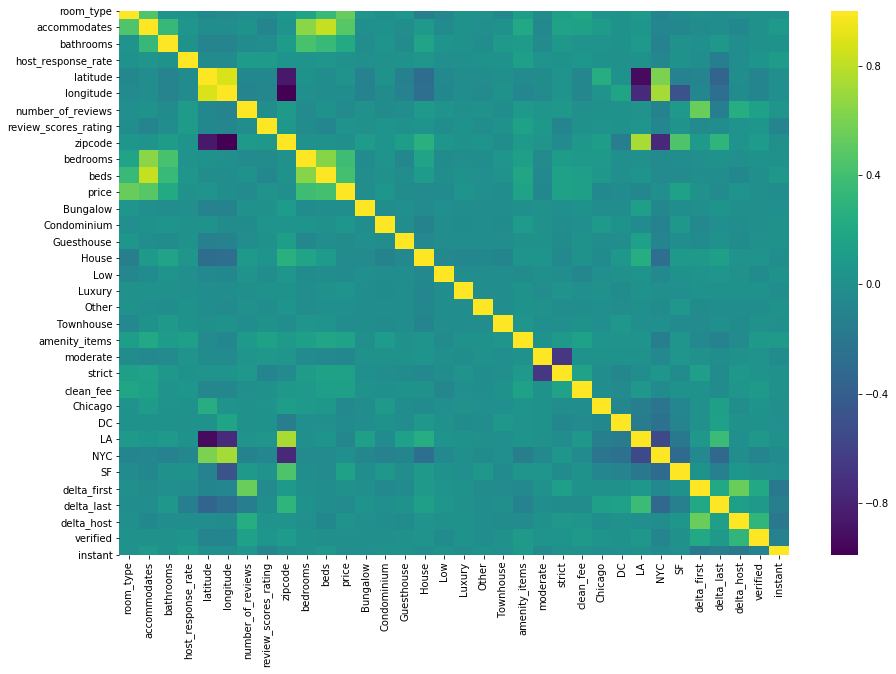

In [7]:
datacorr = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(datacorr, cmap = 'viridis');

## Regresión Lineal - Elastic Net

Usando 33 columnas

In [8]:
X = data.drop(['price','zipcode','latitude','longitude'],axis = 1)
y = data.price

In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [11]:
#elastic = ElasticNet().fit(X_train,y_train)
#y_pred_elastic = elastic.predict(X_test)

In [12]:
#mx_result['elastic_33'] = [mse(y_test, y_pred_elastic),mse(y_test,y_pred_elastic)**0.5]

Usando 5 columnas con alta correlación a price

In [13]:
X_pcorr = data[['accommodates','bathrooms','bedrooms','latitude']]

In [14]:
X_train_pcorr, X_test_pcorr = train_test_split(X_pcorr, test_size = 0.2)

In [15]:
elastic_pcorr = ElasticNet().fit(X_train_pcorr,y_train)
y_pred_elastic_pcorr = elastic_pcorr.predict(X_test_pcorr)

In [16]:
space={
    'alpha':hp.quniform('x_alpha', 1., 10., 1.),
}

In [17]:
def objetivo_elastic_pcorr(space):
    
    elastic_pcorr_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_elastic_pcorr_opt=elastic_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_elastic_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [18]:
best_elastic_pcorr=fmin(fn=objetivo_elastic_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 219.96it/s, best loss: 62.21453916548475]


In [19]:
elastic_pcorr_opt = ElasticNet(
    alpha=best_elastic_pcorr['x_alpha']).fit(X_train_pcorr,y_train)
y_pred_elastic_pcorr_opt = elastic_pcorr_opt.predict(X_test_pcorr)

In [20]:
mx_result['elastic_5_pcorr_opt'] = [mse(y_test, y_pred_elastic_pcorr_opt),mse(y_test,y_pred_elastic_pcorr_opt)**0.5,y_pred_elastic_pcorr_opt.mean(),y_pred_elastic_pcorr_opt.std(),y_pred_elastic_pcorr_opt.var()]

Usando 11 columnas

In [21]:
X_feat = data[['bathrooms','bedrooms','number_of_reviews','review_scores_rating','Chicago','DC','LA','NYC','SF','delta_host']]

In [22]:
X_train_feat, X_test_feat = train_test_split(X_feat, test_size = 0.2)

In [23]:
elastic_feat = ElasticNet().fit(X_train_feat,y_train)
y_pred_elastic_feat = elastic_feat.predict(X_test_feat)

In [24]:
def objetivo_elastic_feat(space):
    
    elastic_feat_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_elastic_feat_opt=elastic_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_elastic_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [25]:
best_elastic_feat=fmin(fn=objetivo_elastic_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 212.68it/s, best loss: 62.214263369251164]


In [26]:
elastic_feat_opt = ElasticNet(
    alpha=best_elastic_feat['x_alpha']).fit(X_train_feat,y_train)
y_pred_elastic_feat_opt = elastic_feat_opt.predict(X_test_feat)

In [27]:
mx_result['elastic_11_feat_opt'] = [mse(y_test, y_pred_elastic_feat_opt),mse(y_test,y_pred_elastic_feat_opt)**0.5,y_pred_elastic_feat_opt.mean(),y_pred_elastic_feat_opt.std(),y_pred_elastic_feat_opt.var()]

7 columnas

In [28]:
X_num = data[['accommodates','bathrooms','latitude','number_of_reviews','review_scores_rating','bedrooms','beds']]

In [29]:
X_train_num, X_test_num = train_test_split(X_num, test_size = 0.2)

In [30]:
elastic_num = ElasticNet().fit(X_train_num,y_train)
y_pred_elastic_num = elastic_num.predict(X_test_num)

In [31]:
def objetivo_elastic_num(space):
    
    elastic_num_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_num_opt.fit(X_train_num, y_train)
    
    y_pred_elastic_num_opt=elastic_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_elastic_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [32]:
best_elastic_num=fmin(fn=objetivo_elastic_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 226.48it/s, best loss: 62.21442686184873]


In [33]:
elastic_num_opt = ElasticNet(
    alpha=best_elastic_num['x_alpha']).fit(X_train_num,y_train)
y_pred_elastic_num_opt = elastic_num_opt.predict(X_test_num)

In [34]:
mx_result['elastic_7_num_opt'] = [mse(y_test, y_pred_elastic_num_opt),mse(y_test,y_pred_elastic_num_opt)**0.5,y_pred_elastic_num_opt.mean(),y_pred_elastic_num_opt.std(),y_pred_elastic_num_opt.var()]

12 columnas

In [35]:
X_ubi = data[['delta_host','bathrooms','beds','Bungalow','Condominium','Guesthouse','House','Low','Luxury','Other','Townhouse','review_scores_rating']]

In [36]:
X_train_ubi, X_test_ubi = train_test_split(X_ubi, test_size = 0.2)

In [37]:
elastic_ubi = ElasticNet().fit(X_train_ubi,y_train)
y_pred_elastic_ubi = elastic_ubi.predict(X_test_ubi)

In [38]:
def objetivo_elastic_ubi(space):
    
    elastic_ubi_opt=ElasticNet(
        alpha=space['alpha']
    )
    
    elastic_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_elastic_ubi_opt=elastic_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_elastic_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [39]:
best_elastic_ubi=fmin(fn=objetivo_elastic_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 197.67it/s, best loss: 62.21436165323165]


In [40]:
elastic_ubi_opt = ElasticNet(
    alpha=best_elastic_ubi['x_alpha']).fit(X_train_ubi,y_train)
y_pred_elastic_ubi_opt = elastic_ubi_opt.predict(X_test_ubi)

In [41]:
mx_result['elastic_12_ubi_opt'] = [mse(y_test, y_pred_elastic_ubi_opt),mse(y_test,y_pred_elastic_ubi_opt)**0.5,y_pred_elastic_ubi_opt.mean(),y_pred_elastic_ubi_opt.std(),y_pred_elastic_ubi_opt.var()]

## SVR

33 columnas

In [42]:
import warnings
warnings.simplefilter('ignore')

from sklearn.svm import SVR

In [43]:
svr = SVR().fit(X_train,y_train)
y_pred_svr = svr.predict(X_test)

In [44]:
space={
    'C':hp.quniform('x_C', 1, 15, 1),
    'epsilon':hp.uniform('x_epsilon', 0.1, 1.0),
    'coef0':hp.quniform('x_coef0', 0.5, 5.0, 0.5),
    'degree':hp.quniform('x_degree', 4, 20, 4),
}

In [45]:
def objetivo_svr_opt(space):
    
    svr_opt=SVR(
        C=space['C'],
        epsilon=space['epsilon'],
        coef0=space['coef0'],
        degree=int(space['degree'])
    )
    
    svr_opt.fit(X_train, y_train)
    
    y_pred_opt=svr_opt.predict(X_test)
    
    rmse=mse(y_test, y_pred_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [46]:
best_svr=fmin(fn=objetivo_svr_opt, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [03:52<00:00, 23.21s/it, best loss: 52.728454399668486]


In [47]:
svr_33_opt = SVR(
    C=best_svr['x_C'],
    epsilon=best_svr['x_epsilon'],
    coef0=best_svr['x_coef0'],
    degree=best_svr['x_degree']).fit(X_train,y_train)
y_pred_svr_33_opt = svr_33_opt.predict(X_test)

In [48]:
mx_result['svr_33_opt'] = [mse(y_test, y_pred_svr_33_opt),mse(y_test,y_pred_svr_33_opt)**0.5,y_pred_svr_33_opt.mean(),y_pred_svr_33_opt.std(),y_pred_svr_33_opt.var()]

5 columnas

In [49]:
#svr_pcorr = SVR().fit(X_train_pcorr,y_train)
#y_pred_svr_pcorr = svr_pcorr.predict(X_test_pcorr)

In [50]:
#mx_result['svr_5_pcorr'] = [mse(y_test, y_pred_svr_pcorr),mse(y_test,y_pred_svr_pcorr)**0.5]

11 columnas

In [51]:
#svr_feat = SVR().fit(X_train_feat,y_train)
#y_pred_svr_feat = svr_feat.predict(X_test_feat)

In [52]:
#mx_result['svr_11_feat'] = [mse(y_test, y_pred_svr_feat),mse(y_test,y_pred_svr_feat)**0.5]

7 columnas

In [53]:
#svr_num = SVR().fit(X_train_num,y_train)
#y_pred_svr_num = svr_num.predict(X_test_num)

In [54]:
#mx_result['svr_7_num'] = [mse(y_test, y_pred_svr_num),mse(y_test,y_pred_svr_num)**0.5]

12 columnas

In [55]:
#svr_ubi = SVR().fit(X_train_ubi,y_train)
#y_pred_svr_ubi = svr_ubi.predict(X_test_ubi)

In [56]:
#mx_result['svr_12_ubi'] = [mse(y_test, y_pred_svr_ubi),mse(y_test,y_pred_svr_ubi)**0.5]

## Random Forest Regression

33 columnas

In [57]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [58]:
#rfr = RFR().fit(X_train,y_train)
#y_pred_rfr = rfr.predict(X_test)

In [59]:
#mx_result['rfr_33'] = [mse(y_test, y_pred_rfr),mse(y_test,y_pred_rfr)**0.5]

5 columnas

In [60]:
rfr_pcorr = RFR().fit(X_train_pcorr,y_train)
y_pred_rfr_pcorr = rfr_pcorr.predict(X_test_pcorr)

In [61]:
space={
    'min_samples_leaf':hp.uniform('x_min_samples_leaf', 0.1, 0.5),
    'min_samples_split':hp.quniform('x_min_samples_split', 2, 10, 2),
    'min_weight_fraction_leaf':hp.uniform('x_min_weight_fraction_leaf', 0.1, 0.5),
    'n_estimators':hp.quniform('x_n_estimators', 10, 50, 5)
}

In [62]:
def objetivo_rfr_pcorr(space):
    
    rfr_pcorr_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_rfr_pcorr_opt=rfr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_rfr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [63]:
best_rfr_pcorr=fmin(fn=objetivo_rfr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 12.16it/s, best loss: 62.20957044989083]


In [64]:
rfr_pcorr_opt = RFR(
    min_samples_leaf=best_rfr_pcorr['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_pcorr['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_pcorr['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_pcorr['x_n_estimators'])).fit(X_train_pcorr,y_train)
y_pred_rfr_pcorr_opt = rfr_pcorr_opt.predict(X_test_pcorr)

In [65]:
mx_result['rfr_5_pcorr_opt'] = [mse(y_test, y_pred_rfr_pcorr_opt),mse(y_test,y_pred_rfr_pcorr_opt)**0.5,y_pred_rfr_pcorr_opt.mean(),y_pred_rfr_pcorr_opt.std(),y_pred_rfr_pcorr_opt.var()]

11 columnas

In [66]:
rfr_feat = RFR().fit(X_train_feat,y_train)
y_pred_rfr_feat = rfr_feat.predict(X_test_feat)

In [67]:
def objetivo_rfr_feat(space):
    
    rfr_feat_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_rfr_feat_opt=rfr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_rfr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [68]:
best_rfr_feat=fmin(fn=objetivo_rfr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 11.48it/s, best loss: 62.21197282836503]


In [69]:
rfr_feat_opt = RFR(
    min_samples_leaf=best_rfr_feat['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_feat['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_feat['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_feat['x_n_estimators'])).fit(X_train_feat,y_train)
y_pred_rfr_feat_opt = rfr_feat_opt.predict(X_test_feat)

In [70]:
mx_result['rfr_11_feat_opt'] = [mse(y_test, y_pred_rfr_feat_opt),mse(y_test,y_pred_rfr_feat_opt)**0.5,y_pred_rfr_feat_opt.mean(),y_pred_rfr_feat_opt.std(),y_pred_rfr_feat_opt.var()]

7 columnas

In [71]:
rfr_num = RFR().fit(X_train_num,y_train)
y_pred_rfr_num = rfr_num.predict(X_test_num)

In [72]:
def objetivo_rfr_num(space):
    
    rfr_num_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_num_opt.fit(X_train_num, y_train)
    
    y_pred_rfr_num_opt=rfr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_rfr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [73]:
best_rfr_num=fmin(fn=objetivo_rfr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:01<00:00,  7.58it/s, best loss: 62.19508773008367]


In [74]:
rfr_num_opt = RFR(
    min_samples_leaf=best_rfr_num['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_num['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_num['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_num['x_n_estimators'])).fit(X_train_num,y_train)
y_pred_rfr_num_opt = rfr_num_opt.predict(X_test_num)

In [75]:
mx_result['rfr_7_num_opt'] = [mse(y_test, y_pred_rfr_num_opt),mse(y_test,y_pred_rfr_num_opt)**0.5,y_pred_rfr_num_opt.mean(),y_pred_rfr_num_opt.std(),y_pred_rfr_num_opt.var()]

12 columnas

In [76]:
rfr_ubi = RFR().fit(X_train_ubi,y_train)
y_pred_rfr_ubi = rfr_ubi.predict(X_test_ubi)

In [77]:
def objetivo_rfr_ubi(space):
    
    rfr_ubi_opt=RFR(
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators'])
    )
    
    rfr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_rfr_ubi_opt=rfr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_rfr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [78]:
best_rfr_ubi=fmin(fn=objetivo_rfr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:00<00:00, 15.29it/s, best loss: 62.21126129372443]


In [79]:
rfr_ubi_opt = RFR(
    min_samples_leaf=best_rfr_ubi['x_min_samples_leaf'],
    min_samples_split=int(best_rfr_ubi['x_min_samples_split']),
    min_weight_fraction_leaf=best_rfr_ubi['x_min_weight_fraction_leaf'],
    n_estimators=int(best_rfr_ubi['x_n_estimators'])).fit(X_train_ubi,y_train)
y_pred_rfr_ubi_opt = rfr_ubi_opt.predict(X_test_ubi)

In [80]:
mx_result['rfr_12_ubi_opt'] = [mse(y_test, y_pred_rfr_ubi_opt),mse(y_test,y_pred_rfr_ubi_opt)**0.5,y_pred_rfr_ubi_opt.mean(),y_pred_rfr_ubi_opt.std(),y_pred_rfr_ubi_opt.var()]

## KNN

33 columnas

In [81]:
from sklearn.neighbors import KNeighborsRegressor as KNNR

In [82]:
#knnr = KNNR().fit(X_train,y_train)
#y_pred_knnr = knnr.predict(X_test)

In [83]:
#mx_result['knnr_33'] = [mse(y_test, y_pred_knnr),mse(y_test,y_pred_knnr)**0.5]

5 columnas

In [84]:
knnr_pcorr = KNNR().fit(X_train_pcorr,y_train)
y_pred_knnr_pcorr = knnr_pcorr.predict(X_test_pcorr)

In [85]:
space={
    'leaf_size':hp.quniform('x_leaf_size', 10, 100, 5),
    'n_neighbors':hp.quniform('x_n_neighbors', 5, 50, 5),
    'p':hp.quniform('x_p', 2, 20, 2),
}

In [86]:
def objetivo_knnr_pcorr(space):
    
    knnr_pcorr_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_knnr_pcorr_opt=knnr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_knnr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [87]:
best_knnr_pcorr=fmin(fn=objetivo_knnr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:04<00:00,  2.28it/s, best loss: 62.83317391368264]


In [88]:
knnr_pcorr_opt = KNNR(
    leaf_size=best_knnr_pcorr['x_leaf_size'],
    n_neighbors=int(best_knnr_pcorr['x_n_neighbors']),
    p=best_knnr_pcorr['x_p']).fit(X_train_pcorr,y_train)
y_pred_knnr_pcorr_opt = knnr_pcorr_opt.predict(X_test_pcorr)

In [89]:
mx_result['knnr_5_pcorr_opt'] = [mse(y_test, y_pred_knnr_pcorr_opt),mse(y_test,y_pred_knnr_pcorr_opt)**0.5,y_pred_knnr_pcorr_opt.mean(),y_pred_knnr_pcorr_opt.std(),y_pred_knnr_pcorr_opt.var()]

11 columnas

In [90]:
knnr_feat = KNNR().fit(X_train_feat,y_train)
y_pred_knnr_feat = knnr_feat.predict(X_test_feat)

In [91]:
def objetivo_knnr_feat(space):
    
    knnr_feat_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_knnr_feat_opt=knnr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_knnr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [92]:
best_knnr_feat=fmin(fn=objetivo_knnr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:03<00:00,  3.31it/s, best loss: 62.801640940518475]


In [93]:
knnr_feat_opt = KNNR(
    leaf_size=best_knnr_feat['x_leaf_size'],
    n_neighbors=int(best_knnr_feat['x_n_neighbors']),
    p=best_knnr_feat['x_p']).fit(X_train_feat,y_train)
y_pred_knnr_feat_opt = knnr_feat_opt.predict(X_test_feat)

In [94]:
mx_result['knnr_11_feat_opt'] = [mse(y_test, y_pred_knnr_feat_opt),mse(y_test,y_pred_knnr_feat_opt)**0.5,y_pred_knnr_feat_opt.mean(),y_pred_knnr_feat_opt.std(),y_pred_knnr_feat_opt.var()]

7 columnas

In [95]:
knnr_num = KNNR().fit(X_train_num,y_train)
y_pred_knnr_num = knnr_num.predict(X_test_num)

In [96]:
def objetivo_knnr_num(space):
    
    knnr_num_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_num_opt.fit(X_train_num, y_train)
    
    y_pred_knnr_num_opt=knnr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_knnr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [97]:
best_knnr_num=fmin(fn=objetivo_knnr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:02<00:00,  3.37it/s, best loss: 62.89917463137478]


In [98]:
knnr_num_opt = KNNR(
    leaf_size=best_knnr_num['x_leaf_size'],
    n_neighbors=int(best_knnr_num['x_n_neighbors']),
    p=best_knnr_num['x_p']).fit(X_train_num,y_train)
y_pred_knnr_num_opt = knnr_num_opt.predict(X_test_num)

In [99]:
mx_result['knnr_7_num_opt'] = [mse(y_test, y_pred_knnr_num_opt),mse(y_test,y_pred_knnr_num_opt)**0.5,y_pred_knnr_num_opt.mean(),y_pred_knnr_num_opt.std(),y_pred_knnr_num_opt.var()]

12 columnas

In [100]:
knnr_ubi = KNNR().fit(X_train_ubi,y_train)
y_pred_knnr_ubi = knnr_ubi.predict(X_test_ubi)

In [101]:
def objetivo_knnr_ubi(space):
    
    knnr_ubi_opt=KNNR(
        leaf_size=space['leaf_size'],
        n_neighbors=int(space['n_neighbors']),
        p=space['p'],
    )
    
    knnr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_knnr_ubi_opt=knnr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_knnr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [102]:
best_knnr_ubi=fmin(fn=objetivo_knnr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:04<00:00,  2.39it/s, best loss: 62.63245173099274]


In [103]:
knnr_ubi_opt = KNNR(
    leaf_size=best_knnr_ubi['x_leaf_size'],
    n_neighbors=int(best_knnr_ubi['x_n_neighbors']),
    p=best_knnr_ubi['x_p']).fit(X_train_ubi,y_train)
y_pred_knnr_ubi_opt = knnr_ubi_opt.predict(X_test_ubi)

In [104]:
mx_result['knnr_12_ubi_opt'] = [mse(y_test, y_pred_knnr_ubi_opt),mse(y_test,y_pred_knnr_ubi_opt)**0.5,y_pred_knnr_ubi_opt.mean(),y_pred_knnr_ubi_opt.std(),y_pred_knnr_ubi_opt.var()]

## Grad Boost Regressor

33 columnas

In [105]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [106]:
#gbr = GBR().fit(X_train,y_train)
#y_pred_gbr = gbr.predict(X_test)

In [107]:
#mx_result['gbr_33'] = [mse(y_test, y_pred_gbr),mse(y_test,y_pred_gbr)**0.5]

5 columnas

In [108]:
gbr_pcorr = GBR().fit(X_train_pcorr,y_train)
y_pred_gbr_pcorr = gbr_pcorr.predict(X_test_pcorr)

In [109]:
space={
    'alpha':hp.uniform('x_alpha', 0.1, 1.0),
    'learning_rate':hp.uniform('x_learning_rate', 0.1, 10.0),
    'max_depth':hp.quniform('x_max_depth', 1, 15, 1),
    'min_impurity_decrease':hp.uniform('x_min_impurity_decrease',0.0, 5.0),
    'min_samples_leaf':hp.uniform('x_min_samples_leaf', 1, 10),
    'min_samples_split':hp.quniform('x_min_samples_split', 2, 10, 2),
    'min_weight_fraction_leaf':hp.uniform('x_min_weight_fraction_leaf', 0.1, 0.5),
    'n_estimators':hp.quniform('x_n_estimators', 50, 150, 5),
    'subsample':hp.uniform('x_subsample', 0.1, 1.0),
    'tol':hp.uniform('x_tol',0.001, 0.1),
    'validation_fraction':hp.uniform('x_validation_fraction', 0.1, 1.0)
}

In [110]:
def objetivo_gbr_pcorr(space):
    
    gbr_pcorr_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_gbr_pcorr_opt=gbr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_gbr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [111]:
best_gbr_pcorr=fmin(fn=objetivo_gbr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:03<00:00,  3.33it/s, best loss: 62.39861260453021]    


In [112]:
gbr_pcorr_opt = GBR(
    alpha=best_gbr_pcorr['x_alpha'],
    learning_rate=best_gbr_pcorr['x_learning_rate'],
    max_depth=best_gbr_pcorr['x_max_depth'],
    min_impurity_decrease=best_gbr_pcorr['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_pcorr['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_pcorr['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_pcorr['x_min_weight_fraction_leaf'],
    subsample=best_gbr_pcorr['x_subsample'],
    tol=best_gbr_pcorr['x_tol'],
    validation_fraction=best_gbr_pcorr['x_validation_fraction']).fit(X_train_pcorr,y_train)
y_pred_gbr_pcorr_opt = gbr_pcorr_opt.predict(X_test_pcorr)

In [113]:
mx_result['gbr_5_pcorr_opt'] = [mse(y_test, y_pred_gbr_pcorr_opt),mse(y_test,y_pred_gbr_pcorr_opt)**0.5,y_pred_gbr_pcorr_opt.mean(),y_pred_gbr_pcorr_opt.std(),y_pred_gbr_pcorr_opt.var()]

11 columnas

In [114]:
gbr_feat = GBR().fit(X_train_feat,y_train)
y_pred_gbr_feat = gbr_feat.predict(X_test_feat)

In [115]:
def objetivo_gbr_feat(space):
    
    gbr_feat_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_gbr_feat_opt=gbr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_gbr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [116]:
best_gbr_feat=fmin(fn=objetivo_gbr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:04<00:00,  2.37it/s, best loss: 62.33773442867815]    


In [117]:
gbr_feat_opt = GBR(
    alpha=best_gbr_feat['x_alpha'],
    learning_rate=best_gbr_feat['x_learning_rate'],
    max_depth=best_gbr_feat['x_max_depth'],
    min_impurity_decrease=best_gbr_feat['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_feat['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_feat['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_feat['x_min_weight_fraction_leaf'],
    subsample=best_gbr_feat['x_subsample'],
    tol=best_gbr_feat['x_tol'],
    validation_fraction=best_gbr_feat['x_validation_fraction']).fit(X_train_feat,y_train)
y_pred_gbr_feat_opt = gbr_feat_opt.predict(X_test_feat)

In [118]:
mx_result['gbr_11_feat_opt'] = [mse(y_test, y_pred_gbr_feat_opt),mse(y_test,y_pred_gbr_feat_opt)**0.5,y_pred_gbr_feat_opt.mean(),y_pred_gbr_feat_opt.std(),y_pred_gbr_feat_opt.var()]

7 columnas

In [119]:
gbr_num = GBR().fit(X_train_num,y_train)
y_pred_gbr_num = gbr_num.predict(X_test_num)

In [120]:
def objetivo_gbr_num(space):
    
    gbr_num_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_num_opt.fit(X_train_num, y_train)
    
    y_pred_gbr_num_opt=gbr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_gbr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [121]:
best_gbr_num=fmin(fn=objetivo_gbr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:03<00:00,  2.75it/s, best loss: 62.26536323857805]    


In [122]:
gbr_num_opt = GBR(
    alpha=best_gbr_num['x_alpha'],
    learning_rate=best_gbr_num['x_learning_rate'],
    max_depth=best_gbr_num['x_max_depth'],
    min_impurity_decrease=best_gbr_num['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_num['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_num['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_num['x_min_weight_fraction_leaf'],
    subsample=best_gbr_num['x_subsample'],
    tol=best_gbr_num['x_tol'],
    validation_fraction=best_gbr_num['x_validation_fraction']).fit(X_train_num,y_train)
y_pred_gbr_num_opt = gbr_num_opt.predict(X_test_num)

In [123]:
mx_result['gbr_7_num_opt'] = [mse(y_test, y_pred_gbr_num_opt),mse(y_test,y_pred_gbr_num_opt)**0.5,y_pred_gbr_num_opt.mean(),y_pred_gbr_num_opt.std(),y_pred_gbr_num_opt.var()]

12 columnas

In [124]:
gbr_ubi = GBR().fit(X_train_ubi,y_train)
y_pred_gbr_ubi = gbr_ubi.predict(X_test_ubi)

In [125]:
def objetivo_gbr_ubi(space):
    
    gbr_ubi_opt=GBR(
        alpha=space['alpha'],
        learning_rate=space['learning_rate'],
        max_depth=space['max_depth'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction']
    )
    
    gbr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_gbr_ubi_opt=gbr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_gbr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [126]:
best_gbr_ubi=fmin(fn=objetivo_gbr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:04<00:00,  2.21it/s, best loss: 62.29080574058767]   


In [127]:
gbr_ubi_opt = GBR(
    alpha=best_gbr_ubi['x_alpha'],
    learning_rate=best_gbr_ubi['x_learning_rate'],
    max_depth=best_gbr_ubi['x_max_depth'],
    min_impurity_decrease=best_gbr_ubi['x_min_impurity_decrease'],
    min_samples_leaf=int(best_gbr_ubi['x_min_samples_leaf']),
    min_samples_split=int(best_gbr_ubi['x_min_samples_split']),
    min_weight_fraction_leaf=best_gbr_ubi['x_min_weight_fraction_leaf'],
    subsample=best_gbr_ubi['x_subsample'],
    tol=best_gbr_ubi['x_tol'],
    validation_fraction=best_gbr_ubi['x_validation_fraction']).fit(X_train_ubi,y_train)
y_pred_gbr_ubi_opt = gbr_ubi_opt.predict(X_test_ubi)

In [128]:
mx_result['gbr_12_ubi_opt'] = [mse(y_test, y_pred_gbr_ubi_opt),mse(y_test,y_pred_gbr_ubi_opt)**0.5,y_pred_gbr_ubi_opt.mean(),y_pred_gbr_ubi_opt.std(),y_pred_gbr_ubi_opt.var()]

## XGBoost

33 columnas

In [129]:
from xgboost import XGBRegressor as XGBR

In [130]:
#xgbr = XGBR().fit(X_train,y_train)
#y_pred_xgbr = xgbr.predict(X_test)

In [131]:
#mx_result['xgbr_33'] = [mse(y_test, y_pred_xgbr),mse(y_test,y_pred_xgbr)**0.5]

5 columnas

In [132]:
xgbr_pcorr = XGBR().fit(X_train_pcorr,y_train)
y_pred_xgbr_pcorr = xgbr_pcorr.predict(X_test_pcorr)

[15:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [133]:
space={
    'base_score':hp.uniform('x_base_score', 0.5, 5.0),
    'colsample_bylevel':hp.uniform('x_colsample_bylevel',0.1,1),
    'colsample_bynode':hp.uniform('x_colsample_bynode',0.1,1),
    'colsample_bytree':hp.uniform('x_colsample_bytree',0.1,1),
    'gamma':hp.quniform('x_gamma',0,10,1),
    'learning_rate':hp.uniform('x_learning_rate', 0.1, 10.0),
    'max_delta_step':hp.quniform('x_max_delta_step',1,15,1),
    'max_depth':hp.quniform('x_max_depth', 1, 15, 1),
    'min_child_weight':hp.quniform('x_min_child_weight',1,15,1),
    'n_estimators':hp.quniform('x_n_estimators', 50, 150, 5),
    'random_state':hp.uniform('x_random_state',0.1,1),
    'reg_alpha':hp.quniform('x_reg_alpha',1,15,1),
    'subsample':hp.uniform('x_subsample', 0.1, 1.0),
    'reg_lambda':hp.quniform('x_reg_lambda',1,15,1),
    'scale_pos_weight':hp.quniform('x_scale_pos_weight', 1,15,1),
}

In [134]:
def objetivo_xgbr_pcorr(space):
    
    xgbr_pcorr_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_xgbr_pcorr_opt=xgbr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_xgbr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [135]:
best_xgbr_pcorr=fmin(fn=objetivo_xgbr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[15:15:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [136]:
xgbr_pcorr_opt = XGBR(
    base_score=best_xgbr_pcorr['x_base_score'],
    colsample_bylevel=best_xgbr_pcorr['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_pcorr['x_colsample_bynode'],
    colsample_bytree=best_xgbr_pcorr['x_colsample_bytree'],
    gamma=best_xgbr_pcorr['x_gamma'],
    learning_rate=best_xgbr_pcorr['x_learning_rate'],
    max_delta_step=best_xgbr_pcorr['x_max_delta_step'],
    max_depth=int(best_xgbr_pcorr['x_max_depth']),
    min_child_weight=best_xgbr_pcorr['x_min_child_weight'],
    n_estimators=int(best_xgbr_pcorr['x_n_estimators']),
    random_state=int(best_xgbr_pcorr['x_random_state']),
    reg_alpha=best_xgbr_pcorr['x_reg_alpha'],
    subsample=best_xgbr_pcorr['x_subsample'],
    reg_lambda=best_xgbr_pcorr['x_reg_lambda'],
    scale_pos_weight=best_xgbr_pcorr['x_scale_pos_weight']).fit(X_train_pcorr,y_train)
y_pred_xgbr_pcorr_opt = xgbr_pcorr_opt.predict(X_test_pcorr)

[15:15:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [137]:
mx_result['xgbr_5_pcorr_opt'] = [mse(y_test, y_pred_xgbr_pcorr_opt),mse(y_test,y_pred_xgbr_pcorr_opt)**0.5,y_pred_xgbr_pcorr_opt.mean(),y_pred_xgbr_pcorr_opt.std(),y_pred_xgbr_pcorr_opt.var()]

11 columnas

In [138]:
xgbr_feat = XGBR().fit(X_train_feat,y_train)
y_pred_xgbr_feat = xgbr_feat.predict(X_test_feat)

[15:15:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [139]:
def objetivo_xgbr_feat(space):
    
    xgbr_feat_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_xgbr_feat_opt=xgbr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_xgbr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [140]:
best_xgbr_feat=fmin(fn=objetivo_xgbr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[15:15:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [141]:
xgbr_feat_opt = XGBR(
    base_score=best_xgbr_feat['x_base_score'],
    colsample_bylevel=best_xgbr_feat['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_feat['x_colsample_bynode'],
    colsample_bytree=best_xgbr_feat['x_colsample_bytree'],
    gamma=best_xgbr_feat['x_gamma'],
    learning_rate=best_xgbr_feat['x_learning_rate'],
    max_delta_step=best_xgbr_feat['x_max_delta_step'],
    max_depth=int(best_xgbr_feat['x_max_depth']),
    min_child_weight=best_xgbr_feat['x_min_child_weight'],
    n_estimators=int(best_xgbr_feat['x_n_estimators']),
    random_state=int(best_xgbr_feat['x_random_state']),
    reg_alpha=best_xgbr_feat['x_reg_alpha'],
    subsample=best_xgbr_feat['x_subsample'],
    reg_lambda=best_xgbr_feat['x_reg_lambda'],
    scale_pos_weight=best_xgbr_feat['x_scale_pos_weight']).fit(X_train_feat,y_train)
y_pred_xgbr_feat_opt = xgbr_feat_opt.predict(X_test_feat)

[15:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [142]:
mx_result['xgbr_11_feat_opt'] = [mse(y_test, y_pred_xgbr_feat_opt),mse(y_test,y_pred_xgbr_feat_opt)**0.5,y_pred_xgbr_feat_opt.mean(),y_pred_xgbr_feat_opt.std(),y_pred_xgbr_feat_opt.var()]

8 columnas

In [143]:
xgbr_num = XGBR().fit(X_train_num,y_train)
y_pred_xgbr_num = xgbr_num.predict(X_test_num)

[15:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [144]:
def objetivo_xgbr_num(space):
    
    xgbr_num_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_num_opt.fit(X_train_num, y_train)
    
    y_pred_xgbr_num_opt=xgbr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_xgbr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [145]:
best_xgbr_num=fmin(fn=objetivo_xgbr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[15:16:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [146]:
xgbr_num_opt = XGBR(
    base_score=best_xgbr_num['x_base_score'],
    colsample_bylevel=best_xgbr_num['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_num['x_colsample_bynode'],
    colsample_bytree=best_xgbr_num['x_colsample_bytree'],
    gamma=best_xgbr_num['x_gamma'],
    learning_rate=best_xgbr_num['x_learning_rate'],
    max_delta_step=best_xgbr_num['x_max_delta_step'],
    max_depth=int(best_xgbr_num['x_max_depth']),
    min_child_weight=best_xgbr_num['x_min_child_weight'],
    n_estimators=int(best_xgbr_num['x_n_estimators']),
    random_state=int(best_xgbr_num['x_random_state']),
    reg_alpha=best_xgbr_num['x_reg_alpha'],
    subsample=best_xgbr_num['x_subsample'],
    reg_lambda=best_xgbr_num['x_reg_lambda'],
    scale_pos_weight=best_xgbr_num['x_scale_pos_weight']).fit(X_train_num,y_train)
y_pred_xgbr_num_opt = xgbr_num_opt.predict(X_test_num)

[15:16:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [147]:
mx_result['xgbr_8_num_opt'] = [mse(y_test, y_pred_xgbr_num_opt),mse(y_test,y_pred_xgbr_num_opt)**0.5,y_pred_xgbr_num_opt.mean(),y_pred_xgbr_num_opt.std(),y_pred_xgbr_num_opt.var()]

12 columnas

In [148]:
xgbr_ubi = XGBR().fit(X_train_ubi,y_train)
y_pred_xgbr_ubi = xgbr_ubi.predict(X_test_ubi)

[15:16:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [149]:
def objetivo_xgbr_ubi(space):
    
    xgbr_ubi_opt=XGBR(
        base_score=space['base_score'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        learning_rate=space['learning_rate'],
        max_delta_step=space['max_delta_step'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        n_estimators=int(space['n_estimators']),
        random_state=int(space['random_state']),
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
        scale_pos_weight=space['scale_pos_weight'],
    )
    
    xgbr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_xgbr_ubi_opt=xgbr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_xgbr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [150]:
best_xgbr_ubi=fmin(fn=objetivo_xgbr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

[15:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [151]:
xgbr_ubi_opt = XGBR(
    base_score=best_xgbr_ubi['x_base_score'],
    colsample_bylevel=best_xgbr_ubi['x_colsample_bylevel'],
    colsample_bynode=best_xgbr_ubi['x_colsample_bynode'],
    colsample_bytree=best_xgbr_ubi['x_colsample_bytree'],
    gamma=best_xgbr_ubi['x_gamma'],
    learning_rate=best_xgbr_ubi['x_learning_rate'],
    max_delta_step=best_xgbr_ubi['x_max_delta_step'],
    max_depth=int(best_xgbr_ubi['x_max_depth']),
    min_child_weight=best_xgbr_ubi['x_min_child_weight'],
    n_estimators=int(best_xgbr_ubi['x_n_estimators']),
    random_state=int(best_xgbr_ubi['x_random_state']),
    reg_alpha=best_xgbr_ubi['x_reg_alpha'],
    subsample=best_xgbr_ubi['x_subsample'],
    reg_lambda=best_xgbr_ubi['x_reg_lambda'],
    scale_pos_weight=best_xgbr_ubi['x_scale_pos_weight']).fit(X_train_ubi,y_train)
y_pred_xgbr_ubi_opt = xgbr_ubi_opt.predict(X_test_ubi)

[15:16:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [152]:
mx_result['xgbr_12_ubi_opt'] = [mse(y_test, y_pred_xgbr_ubi_opt),mse(y_test,y_pred_xgbr_ubi_opt)**0.5,y_pred_xgbr_ubi_opt.mean(),y_pred_xgbr_ubi_opt.std(),y_pred_xgbr_ubi_opt.var()]

## SDGRegressor

33 columnas

In [153]:
from sklearn.linear_model import SGDRegressor as SGDR

In [154]:
#sgdr = SGDR().fit(X_train,y_train)
#y_pred_sgdr = sgdr.predict(X_test)

In [155]:
#mx_result['sgdr_33'] = [mse(y_test, y_pred_sgdr),mse(y_test,y_pred_sgdr)**0.5]

5 columnas

In [156]:
#sgdr_pcorr = SGDR().fit(X_train_pcorr,y_train)
#y_pred_sgdr_pcorr = sgdr_pcorr.predict(X_test_pcorr)

In [157]:
#mx_result['sgdr_5_pcorr'] = [mse(y_test, y_pred_sgdr_pcorr),mse(y_test,y_pred_sgdr_pcorr)**0.5]

11 columnas

In [158]:
#sgdr_feat = SGDR().fit(X_train_feat,y_train)
#y_pred_sgdr_feat = sgdr_feat.predict(X_test_feat)

In [159]:
#mx_result['sgdr_11_feat'] = [mse(y_test, y_pred_sgdr_feat),mse(y_test,y_pred_sgdr_feat)**0.5]

8 columnas

In [160]:
#sgdr_num = SGDR().fit(X_train_num,y_train)
#y_pred_sgdr_num = sgdr_num.predict(X_test_num)

In [161]:
#mx_result['sgdr_8_num'] = [mse(y_test, y_pred_sgdr_num),mse(y_test,y_pred_sgdr_num)**0.5]

12 columnas

In [162]:
#sgdr_ubi = SGDR().fit(X_train_ubi,y_train)
#y_pred_sgdr_ubi = sgdr_ubi.predict(X_test_ubi)

In [163]:
#mx_result['sgdr_12_ubi'] = [mse(y_test, y_pred_sgdr_ubi),mse(y_test,y_pred_sgdr_ubi)**0.5]

## CatBoost

33 columnas

In [164]:
from catboost import CatBoostRegressor as CTR

In [165]:
#ctr = CTR().fit(X_train,y_train)
#y_pred_ctr = ctr.predict(X_test)

In [166]:
#mx_result['ctr_33'] = [mse(y_test, y_pred_ctr),mse(y_test,y_pred_ctr)**0.5]

5 columns

In [167]:
ctr_pcorr = CTR().fit(X_train_pcorr,y_train)
y_pred_ctr_pcorr = ctr_pcorr.predict(X_test_pcorr)

0:	learn: 62.8701231	total: 56.2ms	remaining: 56.1s
1:	learn: 62.8670072	total: 59.3ms	remaining: 29.6s
2:	learn: 62.8639323	total: 61.8ms	remaining: 20.5s
3:	learn: 62.8610328	total: 64.7ms	remaining: 16.1s
4:	learn: 62.8591738	total: 68.8ms	remaining: 13.7s
5:	learn: 62.8572760	total: 71.1ms	remaining: 11.8s
6:	learn: 62.8561341	total: 73ms	remaining: 10.3s
7:	learn: 62.8527143	total: 75.5ms	remaining: 9.36s
8:	learn: 62.8513450	total: 77.1ms	remaining: 8.48s
9:	learn: 62.8499049	total: 79.1ms	remaining: 7.83s
10:	learn: 62.8465523	total: 81ms	remaining: 7.28s
11:	learn: 62.8441707	total: 83ms	remaining: 6.83s
12:	learn: 62.8422230	total: 85.5ms	remaining: 6.49s
13:	learn: 62.8401241	total: 87.5ms	remaining: 6.16s
14:	learn: 62.8373126	total: 89.5ms	remaining: 5.88s
15:	learn: 62.8351463	total: 91.6ms	remaining: 5.63s
16:	learn: 62.8305032	total: 93.9ms	remaining: 5.43s
17:	learn: 62.8288614	total: 96ms	remaining: 5.24s
18:	learn: 62.8281156	total: 98.1ms	remaining: 5.06s
19:	learn: 

176:	learn: 62.6226584	total: 827ms	remaining: 3.85s
177:	learn: 62.6211587	total: 834ms	remaining: 3.85s
178:	learn: 62.6205526	total: 839ms	remaining: 3.85s
179:	learn: 62.6196494	total: 845ms	remaining: 3.85s
180:	learn: 62.6180425	total: 850ms	remaining: 3.85s
181:	learn: 62.6172074	total: 855ms	remaining: 3.84s
182:	learn: 62.6165605	total: 860ms	remaining: 3.84s
183:	learn: 62.6156973	total: 865ms	remaining: 3.84s
184:	learn: 62.6153364	total: 870ms	remaining: 3.83s
185:	learn: 62.6149831	total: 877ms	remaining: 3.84s
186:	learn: 62.6137020	total: 884ms	remaining: 3.85s
187:	learn: 62.6125925	total: 891ms	remaining: 3.85s
188:	learn: 62.6119503	total: 899ms	remaining: 3.86s
189:	learn: 62.6113152	total: 907ms	remaining: 3.87s
190:	learn: 62.6108727	total: 914ms	remaining: 3.87s
191:	learn: 62.6096097	total: 921ms	remaining: 3.88s
192:	learn: 62.6092802	total: 928ms	remaining: 3.88s
193:	learn: 62.6085831	total: 935ms	remaining: 3.89s
194:	learn: 62.6062533	total: 941ms	remaining:

349:	learn: 62.4510064	total: 1.95s	remaining: 3.62s
350:	learn: 62.4498941	total: 1.96s	remaining: 3.62s
351:	learn: 62.4490146	total: 1.96s	remaining: 3.61s
352:	learn: 62.4479021	total: 1.97s	remaining: 3.6s
353:	learn: 62.4460171	total: 1.97s	remaining: 3.6s
354:	learn: 62.4440423	total: 1.98s	remaining: 3.59s
355:	learn: 62.4423966	total: 1.98s	remaining: 3.58s
356:	learn: 62.4392279	total: 1.99s	remaining: 3.58s
357:	learn: 62.4373360	total: 1.99s	remaining: 3.58s
358:	learn: 62.4367240	total: 2s	remaining: 3.57s
359:	learn: 62.4344782	total: 2.01s	remaining: 3.57s
360:	learn: 62.4329642	total: 2.01s	remaining: 3.57s
361:	learn: 62.4315909	total: 2.02s	remaining: 3.56s
362:	learn: 62.4300387	total: 2.03s	remaining: 3.56s
363:	learn: 62.4287893	total: 2.04s	remaining: 3.56s
364:	learn: 62.4276207	total: 2.04s	remaining: 3.56s
365:	learn: 62.4254434	total: 2.05s	remaining: 3.55s
366:	learn: 62.4247399	total: 2.05s	remaining: 3.54s
367:	learn: 62.4232182	total: 2.06s	remaining: 3.54

516:	learn: 62.1944598	total: 2.94s	remaining: 2.74s
517:	learn: 62.1920770	total: 2.94s	remaining: 2.74s
518:	learn: 62.1914700	total: 2.95s	remaining: 2.73s
519:	learn: 62.1900044	total: 2.96s	remaining: 2.73s
520:	learn: 62.1888776	total: 2.96s	remaining: 2.72s
521:	learn: 62.1866956	total: 2.96s	remaining: 2.71s
522:	learn: 62.1857438	total: 2.97s	remaining: 2.71s
523:	learn: 62.1853982	total: 2.97s	remaining: 2.7s
524:	learn: 62.1828755	total: 2.98s	remaining: 2.7s
525:	learn: 62.1812711	total: 2.99s	remaining: 2.69s
526:	learn: 62.1788630	total: 2.99s	remaining: 2.69s
527:	learn: 62.1779953	total: 3s	remaining: 2.68s
528:	learn: 62.1760516	total: 3.01s	remaining: 2.68s
529:	learn: 62.1747330	total: 3.02s	remaining: 2.67s
530:	learn: 62.1727408	total: 3.02s	remaining: 2.67s
531:	learn: 62.1704454	total: 3.03s	remaining: 2.67s
532:	learn: 62.1691231	total: 3.04s	remaining: 2.66s
533:	learn: 62.1679619	total: 3.04s	remaining: 2.66s
534:	learn: 62.1663922	total: 3.05s	remaining: 2.65

673:	learn: 61.9875486	total: 3.71s	remaining: 1.79s
674:	learn: 61.9869981	total: 3.72s	remaining: 1.79s
675:	learn: 61.9859076	total: 3.72s	remaining: 1.78s
676:	learn: 61.9842841	total: 3.73s	remaining: 1.78s
677:	learn: 61.9830004	total: 3.74s	remaining: 1.77s
678:	learn: 61.9820456	total: 3.74s	remaining: 1.77s
679:	learn: 61.9813468	total: 3.75s	remaining: 1.76s
680:	learn: 61.9803757	total: 3.75s	remaining: 1.76s
681:	learn: 61.9794521	total: 3.76s	remaining: 1.75s
682:	learn: 61.9774156	total: 3.76s	remaining: 1.75s
683:	learn: 61.9763922	total: 3.77s	remaining: 1.74s
684:	learn: 61.9758332	total: 3.77s	remaining: 1.74s
685:	learn: 61.9739600	total: 3.78s	remaining: 1.73s
686:	learn: 61.9726838	total: 3.79s	remaining: 1.72s
687:	learn: 61.9709540	total: 3.79s	remaining: 1.72s
688:	learn: 61.9705034	total: 3.8s	remaining: 1.72s
689:	learn: 61.9696051	total: 3.81s	remaining: 1.71s
690:	learn: 61.9682722	total: 3.81s	remaining: 1.71s
691:	learn: 61.9671144	total: 3.82s	remaining: 

861:	learn: 61.7836587	total: 4.89s	remaining: 783ms
862:	learn: 61.7823145	total: 4.9s	remaining: 777ms
863:	learn: 61.7812119	total: 4.91s	remaining: 772ms
864:	learn: 61.7804170	total: 4.91s	remaining: 766ms
865:	learn: 61.7793001	total: 4.92s	remaining: 761ms
866:	learn: 61.7781097	total: 4.92s	remaining: 755ms
867:	learn: 61.7767258	total: 4.93s	remaining: 749ms
868:	learn: 61.7762487	total: 4.93s	remaining: 743ms
869:	learn: 61.7746925	total: 4.93s	remaining: 738ms
870:	learn: 61.7737331	total: 4.94s	remaining: 732ms
871:	learn: 61.7729810	total: 4.94s	remaining: 725ms
872:	learn: 61.7718836	total: 4.95s	remaining: 720ms
873:	learn: 61.7710704	total: 4.95s	remaining: 714ms
874:	learn: 61.7702697	total: 4.96s	remaining: 708ms
875:	learn: 61.7696406	total: 4.97s	remaining: 703ms
876:	learn: 61.7689422	total: 4.97s	remaining: 698ms
877:	learn: 61.7682142	total: 4.98s	remaining: 692ms
878:	learn: 61.7673205	total: 4.99s	remaining: 687ms
879:	learn: 61.7657349	total: 5s	remaining: 681

In [168]:
space={
    'learning_rate':hp.uniform('x_learning_rate', 0.1, 1.0),
    'max_depth':hp.quniform('x_max_depth', 0, 10, 1),
    'model_size_reg':hp.quniform('x_model_size_reg', 1, 15, 1),
    'border_count':hp.quniform('x_border_count',1,15,1),
    'n_estimators':hp.quniform('x_n_estimators', 50, 150, 5),
    'subsample':hp.uniform('x_subsample', 0.1, 1.0),
    'reg_lambda':hp.quniform('x_reg_lambda',1,15,1)
}

In [169]:
def objetivo_ctr_pcorr(space):
    
    ctr_pcorr_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_ctr_pcorr_opt=ctr_pcorr_opt.predict(X_test_pcorr)
    
    rmse=mse(y_test, y_pred_ctr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [170]:
best_ctr_pcorr=fmin(fn=objetivo_ctr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 62.8675390	total: 8.18ms	remaining: 1.09s 

1:	learn: 62.8611975	total: 15.1ms	remaining: 1s    

2:	learn: 62.8335698	total: 24.8ms	remaining: 1.09s 

3:	learn: 62.8120999	total: 34.2ms	remaining: 1.12s 

4:	learn: 62.8080297	total: 41.2ms	remaining: 1.07s 

5:	learn: 62.7818099	total: 50.7ms	remaining: 1.09s 

6:	learn: 62.7622333	total: 59.7ms	remaining: 1.09s 

7:	learn: 62.7453199	total: 68.9ms	remaining: 1.09s 

8:	learn: 62.7300925	total: 77.2ms	remaining: 1.08s 

9:	learn: 62.7204859	total: 86.1ms	remaining: 1.08s 

10:	learn: 62.7047169	total: 95ms	remaining: 1.07s  

11:	learn: 62.6988593	total: 101ms	remaining: 1.04s 

12:	learn: 62.6928741	total: 110ms	remaining: 1.03s 

13:	learn: 62.6820010	total: 121ms	remaining: 1.04s 

14:	learn: 62.6763831	total: 165ms	remaining: 1.32s 

15:	learn: 62.6699870	total: 184ms	remaining: 1.37s 

16:	learn: 62.6580362	total: 197ms	remaining: 1.37s 

17:	learn: 62.6436019	total: 208ms	remaining: 1.35s 

18:	learn: 62.6307170	total:

11:	learn: 62.6947284	total: 79.5ms	remaining: 351ms                       

12:	learn: 62.6831424	total: 88.2ms	remaining: 353ms                       

13:	learn: 62.6717494	total: 95.2ms	remaining: 347ms                       

14:	learn: 62.6635210	total: 102ms	remaining: 342ms                        

15:	learn: 62.6585083	total: 109ms	remaining: 334ms                        

16:	learn: 62.6517144	total: 116ms	remaining: 328ms                        

17:	learn: 62.6441640	total: 122ms	remaining: 317ms                        

18:	learn: 62.6331594	total: 129ms	remaining: 312ms                        

19:	learn: 62.6202608	total: 137ms	remaining: 307ms                        

20:	learn: 62.6180924	total: 142ms	remaining: 299ms                        

21:	learn: 62.6126694	total: 148ms	remaining: 290ms                        

22:	learn: 62.6067342	total: 153ms	remaining: 280ms                        

23:	learn: 62.6019175	total: 158ms	remaining: 270ms                        


51:	learn: 62.8591165	total: 237ms	remaining: 150ms                          

52:	learn: 62.8589481	total: 241ms	remaining: 146ms                          

53:	learn: 62.8589381	total: 246ms	remaining: 141ms                          

54:	learn: 62.8589369	total: 250ms	remaining: 136ms                          

55:	learn: 62.8589056	total: 254ms	remaining: 132ms                          

56:	learn: 62.8589054	total: 257ms	remaining: 126ms                          

57:	learn: 62.8589016	total: 261ms	remaining: 122ms                          

58:	learn: 62.8589013	total: 266ms	remaining: 117ms                          

59:	learn: 62.8589012	total: 269ms	remaining: 112ms                          

60:	learn: 62.8589012	total: 273ms	remaining: 107ms                          

61:	learn: 62.8588990	total: 277ms	remaining: 103ms                          

62:	learn: 62.8588990	total: 280ms	remaining: 97.9ms                         

63:	learn: 62.8588957	total: 284ms	remaining: 93.2ms

70:	learn: 62.6506619	total: 687ms	remaining: 716ms                         

71:	learn: 62.6495451	total: 699ms	remaining: 709ms                         

72:	learn: 62.6485862	total: 711ms	remaining: 701ms                         

73:	learn: 62.6476888	total: 722ms	remaining: 693ms                         

74:	learn: 62.6469700	total: 734ms	remaining: 685ms                         

75:	learn: 62.6460025	total: 747ms	remaining: 678ms                         

76:	learn: 62.6453937	total: 769ms	remaining: 679ms                         

77:	learn: 62.6446843	total: 780ms	remaining: 670ms                         

78:	learn: 62.6438170	total: 791ms	remaining: 661ms                         

79:	learn: 62.6432591	total: 810ms	remaining: 658ms                         

80:	learn: 62.6427316	total: 822ms	remaining: 650ms                         

81:	learn: 62.6421568	total: 833ms	remaining: 640ms                         

82:	learn: 62.6413969	total: 845ms	remaining: 631ms             

30:	learn: 62.6572520	total: 302ms	remaining: 283ms                         

31:	learn: 62.6559153	total: 311ms	remaining: 272ms                         

32:	learn: 62.6493019	total: 321ms	remaining: 262ms                         

33:	learn: 62.6451563	total: 332ms	remaining: 254ms                         

34:	learn: 62.6423971	total: 340ms	remaining: 243ms                         

35:	learn: 62.6400327	total: 349ms	remaining: 232ms                         

36:	learn: 62.6398943	total: 354ms	remaining: 220ms                         

37:	learn: 62.6355385	total: 363ms	remaining: 210ms                         

38:	learn: 62.6307637	total: 375ms	remaining: 202ms                         

39:	learn: 62.6235746	total: 384ms	remaining: 192ms                         

40:	learn: 62.6194958	total: 393ms	remaining: 182ms                         

41:	learn: 62.6161004	total: 403ms	remaining: 173ms                         

42:	learn: 62.6070151	total: 412ms	remaining: 163ms             

75:	learn: 62.8733444	total: 248ms	remaining: 62.1ms                        

76:	learn: 62.8733444	total: 251ms	remaining: 58.7ms                        

77:	learn: 62.8733444	total: 266ms	remaining: 58ms                          

78:	learn: 62.8733444	total: 275ms	remaining: 55.6ms                        

79:	learn: 62.8733444	total: 279ms	remaining: 52.3ms                        

80:	learn: 62.8733444	total: 281ms	remaining: 48.7ms                        

81:	learn: 62.8733444	total: 285ms	remaining: 45.1ms                        

82:	learn: 62.8733444	total: 289ms	remaining: 41.8ms                        

83:	learn: 62.8733444	total: 292ms	remaining: 38.3ms                        

84:	learn: 62.8733444	total: 296ms	remaining: 34.8ms                        

85:	learn: 62.8733444	total: 299ms	remaining: 31.3ms                        

86:	learn: 62.8733444	total: 302ms	remaining: 27.8ms                        

87:	learn: 62.8733444	total: 306ms	remaining: 24.3ms            

85:	learn: 62.5658103	total: 593ms	remaining: 269ms                         

86:	learn: 62.5644870	total: 600ms	remaining: 262ms                         

87:	learn: 62.5612067	total: 608ms	remaining: 256ms                         

88:	learn: 62.5603358	total: 615ms	remaining: 249ms                         

89:	learn: 62.5570972	total: 622ms	remaining: 242ms                         

90:	learn: 62.5562857	total: 629ms	remaining: 235ms                         

91:	learn: 62.5548037	total: 636ms	remaining: 228ms                         

92:	learn: 62.5509257	total: 644ms	remaining: 222ms                         

93:	learn: 62.5495653	total: 651ms	remaining: 215ms                         

94:	learn: 62.5472958	total: 657ms	remaining: 207ms                         

95:	learn: 62.5446286	total: 663ms	remaining: 200ms                         

96:	learn: 62.5436508	total: 670ms	remaining: 193ms                         

97:	learn: 62.5385221	total: 677ms	remaining: 187ms             

15:	learn: 62.7816242	total: 114ms	remaining: 810ms                         

16:	learn: 62.7771305	total: 121ms	remaining: 805ms                         

17:	learn: 62.7758859	total: 128ms	remaining: 799ms                         

18:	learn: 62.7634624	total: 135ms	remaining: 789ms                         

19:	learn: 62.7610904	total: 141ms	remaining: 773ms                         

20:	learn: 62.7570871	total: 147ms	remaining: 761ms                         

21:	learn: 62.7485667	total: 152ms	remaining: 746ms                         

22:	learn: 62.7410722	total: 157ms	remaining: 730ms                         

23:	learn: 62.7369436	total: 163ms	remaining: 718ms                         

24:	learn: 62.7338573	total: 167ms	remaining: 702ms                         

25:	learn: 62.7281627	total: 172ms	remaining: 690ms                         

26:	learn: 62.7240659	total: 178ms	remaining: 679ms                         

27:	learn: 62.7192668	total: 184ms	remaining: 670ms             

120:	learn: 62.5506145	total: 766ms	remaining: 56.9ms                       

121:	learn: 62.5491615	total: 773ms	remaining: 50.7ms                       

122:	learn: 62.5490203	total: 779ms	remaining: 44.3ms                       

123:	learn: 62.5483190	total: 786ms	remaining: 38ms                         

124:	learn: 62.5481954	total: 792ms	remaining: 31.7ms                       

125:	learn: 62.5480182	total: 799ms	remaining: 25.4ms                       

126:	learn: 62.5466915	total: 806ms	remaining: 19ms                         

127:	learn: 62.5457063	total: 814ms	remaining: 12.7ms                       

128:	learn: 62.5442843	total: 819ms	remaining: 6.35ms                       

129:	learn: 62.5437699	total: 824ms	remaining: 0us                          

0:	learn: 62.8726910	total: 3.81ms	remaining: 511ms                         

1:	learn: 62.8690038	total: 8.58ms	remaining: 571ms                         

2:	learn: 62.8685027	total: 13.9ms	remaining: 610ms             

95:	learn: 62.8521715	total: 445ms	remaining: 181ms                         

96:	learn: 62.8521694	total: 450ms	remaining: 176ms                         

97:	learn: 62.8521643	total: 454ms	remaining: 171ms                         

98:	learn: 62.8521636	total: 458ms	remaining: 167ms                         

99:	learn: 62.8521632	total: 462ms	remaining: 162ms                         

100:	learn: 62.8521528	total: 466ms	remaining: 157ms                        

101:	learn: 62.8521513	total: 470ms	remaining: 152ms                        

102:	learn: 62.8521494	total: 474ms	remaining: 147ms                        

103:	learn: 62.8521489	total: 479ms	remaining: 143ms                        

104:	learn: 62.8521487	total: 483ms	remaining: 138ms                        

105:	learn: 62.8521484	total: 487ms	remaining: 133ms                        

106:	learn: 62.8521483	total: 491ms	remaining: 128ms                        

107:	learn: 62.8521480	total: 495ms	remaining: 124ms            

In [171]:
ctr_pcorr_opt = CTR(
    learning_rate=best_ctr_pcorr['x_learning_rate'],
    max_depth=best_ctr_pcorr['x_max_depth'],
    model_size_reg=best_ctr_pcorr['x_model_size_reg'],
    border_count=best_ctr_pcorr['x_border_count'],
    n_estimators=best_ctr_pcorr['x_n_estimators'],
    subsample=best_ctr_pcorr['x_subsample'],
    reg_lambda=best_ctr_pcorr['x_reg_lambda']).fit(X_train_pcorr,y_train)
y_pred_ctr_pcorr_opt = ctr_pcorr_opt.predict(X_test_pcorr)

0:	learn: 62.8726910	total: 4.63ms	remaining: 620ms
1:	learn: 62.8690038	total: 8.87ms	remaining: 590ms
2:	learn: 62.8685027	total: 13.2ms	remaining: 580ms
3:	learn: 62.8681895	total: 16.8ms	remaining: 549ms
4:	learn: 62.8681895	total: 21ms	remaining: 547ms
5:	learn: 62.8677127	total: 24.8ms	remaining: 533ms
6:	learn: 62.8673837	total: 28.9ms	remaining: 528ms
7:	learn: 62.8673154	total: 33.1ms	remaining: 525ms
8:	learn: 62.8664447	total: 36.8ms	remaining: 515ms
9:	learn: 62.8657763	total: 42.8ms	remaining: 535ms
10:	learn: 62.8657420	total: 46.6ms	remaining: 526ms
11:	learn: 62.8619912	total: 50.7ms	remaining: 519ms
12:	learn: 62.8615692	total: 54.6ms	remaining: 512ms
13:	learn: 62.8594246	total: 58.9ms	remaining: 509ms
14:	learn: 62.8593805	total: 61.9ms	remaining: 495ms
15:	learn: 62.8592541	total: 65.5ms	remaining: 487ms
16:	learn: 62.8589960	total: 69ms	remaining: 479ms
17:	learn: 62.8589049	total: 72.2ms	remaining: 470ms
18:	learn: 62.8587909	total: 75.4ms	remaining: 460ms
19:	lea

In [172]:
mx_result['ctr_5_pcorr_opt'] = [mse(y_test, y_pred_ctr_pcorr_opt),mse(y_test,y_pred_ctr_pcorr_opt)**0.5,y_pred_ctr_pcorr_opt.mean(),y_pred_ctr_pcorr_opt.std(),y_pred_ctr_pcorr_opt.var()]

11 columnas

In [173]:
ctr_feat = CTR().fit(X_train_feat,y_train)
y_pred_ctr_feat = ctr_feat.predict(X_test_feat)

0:	learn: 62.8678019	total: 8.96ms	remaining: 8.95s
1:	learn: 62.8647621	total: 16.5ms	remaining: 8.21s
2:	learn: 62.8620902	total: 24.4ms	remaining: 8.1s
3:	learn: 62.8600125	total: 31.4ms	remaining: 7.83s
4:	learn: 62.8580680	total: 38.3ms	remaining: 7.61s
5:	learn: 62.8553740	total: 46.1ms	remaining: 7.63s
6:	learn: 62.8520363	total: 53.6ms	remaining: 7.6s
7:	learn: 62.8499305	total: 60.5ms	remaining: 7.5s
8:	learn: 62.8450699	total: 68.4ms	remaining: 7.53s
9:	learn: 62.8428942	total: 78.7ms	remaining: 7.79s
10:	learn: 62.8393405	total: 86.2ms	remaining: 7.75s
11:	learn: 62.8360698	total: 94.7ms	remaining: 7.8s
12:	learn: 62.8347314	total: 99.6ms	remaining: 7.56s
13:	learn: 62.8317429	total: 107ms	remaining: 7.57s
14:	learn: 62.8301006	total: 115ms	remaining: 7.52s
15:	learn: 62.8257296	total: 123ms	remaining: 7.55s
16:	learn: 62.8221647	total: 129ms	remaining: 7.46s
17:	learn: 62.8197067	total: 136ms	remaining: 7.41s
18:	learn: 62.8164996	total: 146ms	remaining: 7.55s
19:	learn: 62

161:	learn: 62.4884242	total: 1.2s	remaining: 6.18s
162:	learn: 62.4867864	total: 1.2s	remaining: 6.18s
163:	learn: 62.4845785	total: 1.21s	remaining: 6.18s
164:	learn: 62.4833047	total: 1.22s	remaining: 6.18s
165:	learn: 62.4796256	total: 1.23s	remaining: 6.18s
166:	learn: 62.4774873	total: 1.24s	remaining: 6.17s
167:	learn: 62.4741706	total: 1.25s	remaining: 6.17s
168:	learn: 62.4727397	total: 1.25s	remaining: 6.17s
169:	learn: 62.4693725	total: 1.26s	remaining: 6.17s
170:	learn: 62.4676289	total: 1.27s	remaining: 6.16s
171:	learn: 62.4630229	total: 1.27s	remaining: 6.14s
172:	learn: 62.4620214	total: 1.28s	remaining: 6.13s
173:	learn: 62.4605369	total: 1.29s	remaining: 6.12s
174:	learn: 62.4603317	total: 1.29s	remaining: 6.1s
175:	learn: 62.4582315	total: 1.3s	remaining: 6.09s
176:	learn: 62.4578273	total: 1.31s	remaining: 6.08s
177:	learn: 62.4567905	total: 1.32s	remaining: 6.08s
178:	learn: 62.4557743	total: 1.32s	remaining: 6.08s
179:	learn: 62.4533393	total: 1.33s	remaining: 6.0

317:	learn: 62.1946211	total: 2.29s	remaining: 4.9s
318:	learn: 62.1926963	total: 2.29s	remaining: 4.89s
319:	learn: 62.1897859	total: 2.3s	remaining: 4.88s
320:	learn: 62.1863495	total: 2.31s	remaining: 4.88s
321:	learn: 62.1837788	total: 2.31s	remaining: 4.87s
322:	learn: 62.1809429	total: 2.32s	remaining: 4.87s
323:	learn: 62.1770837	total: 2.33s	remaining: 4.86s
324:	learn: 62.1718825	total: 2.33s	remaining: 4.85s
325:	learn: 62.1671977	total: 2.34s	remaining: 4.84s
326:	learn: 62.1640648	total: 2.35s	remaining: 4.84s
327:	learn: 62.1617268	total: 2.36s	remaining: 4.83s
328:	learn: 62.1588686	total: 2.37s	remaining: 4.83s
329:	learn: 62.1565606	total: 2.37s	remaining: 4.82s
330:	learn: 62.1540387	total: 2.38s	remaining: 4.81s
331:	learn: 62.1527688	total: 2.39s	remaining: 4.8s
332:	learn: 62.1515405	total: 2.39s	remaining: 4.8s
333:	learn: 62.1511857	total: 2.4s	remaining: 4.79s
334:	learn: 62.1499428	total: 2.41s	remaining: 4.78s
335:	learn: 62.1473682	total: 2.41s	remaining: 4.77

474:	learn: 61.7602296	total: 3.4s	remaining: 3.76s
475:	learn: 61.7561248	total: 3.41s	remaining: 3.75s
476:	learn: 61.7516319	total: 3.42s	remaining: 3.75s
477:	learn: 61.7496263	total: 3.42s	remaining: 3.74s
478:	learn: 61.7460598	total: 3.43s	remaining: 3.73s
479:	learn: 61.7424160	total: 3.44s	remaining: 3.72s
480:	learn: 61.7390837	total: 3.44s	remaining: 3.71s
481:	learn: 61.7362965	total: 3.45s	remaining: 3.71s
482:	learn: 61.7338772	total: 3.46s	remaining: 3.7s
483:	learn: 61.7306328	total: 3.46s	remaining: 3.69s
484:	learn: 61.7285427	total: 3.47s	remaining: 3.69s
485:	learn: 61.7252453	total: 3.48s	remaining: 3.68s
486:	learn: 61.7217314	total: 3.48s	remaining: 3.67s
487:	learn: 61.7180694	total: 3.49s	remaining: 3.66s
488:	learn: 61.7142470	total: 3.5s	remaining: 3.65s
489:	learn: 61.7122740	total: 3.51s	remaining: 3.65s
490:	learn: 61.7106920	total: 3.51s	remaining: 3.64s
491:	learn: 61.7082534	total: 3.52s	remaining: 3.63s
492:	learn: 61.7048969	total: 3.52s	remaining: 3.

632:	learn: 61.3517249	total: 4.5s	remaining: 2.61s
633:	learn: 61.3496955	total: 4.5s	remaining: 2.6s
634:	learn: 61.3482193	total: 4.51s	remaining: 2.59s
635:	learn: 61.3456505	total: 4.52s	remaining: 2.59s
636:	learn: 61.3441025	total: 4.53s	remaining: 2.58s
637:	learn: 61.3429241	total: 4.54s	remaining: 2.57s
638:	learn: 61.3401664	total: 4.54s	remaining: 2.56s
639:	learn: 61.3397667	total: 4.55s	remaining: 2.56s
640:	learn: 61.3378819	total: 4.55s	remaining: 2.55s
641:	learn: 61.3364829	total: 4.56s	remaining: 2.54s
642:	learn: 61.3342819	total: 4.56s	remaining: 2.53s
643:	learn: 61.3315227	total: 4.57s	remaining: 2.52s
644:	learn: 61.3292904	total: 4.58s	remaining: 2.52s
645:	learn: 61.3277528	total: 4.58s	remaining: 2.51s
646:	learn: 61.3238556	total: 4.59s	remaining: 2.5s
647:	learn: 61.3219315	total: 4.6s	remaining: 2.5s
648:	learn: 61.3182497	total: 4.6s	remaining: 2.49s
649:	learn: 61.3157704	total: 4.61s	remaining: 2.48s
650:	learn: 61.3127128	total: 4.62s	remaining: 2.47s


791:	learn: 60.9863777	total: 5.62s	remaining: 1.48s
792:	learn: 60.9846412	total: 5.63s	remaining: 1.47s
793:	learn: 60.9819743	total: 5.64s	remaining: 1.46s
794:	learn: 60.9807771	total: 5.65s	remaining: 1.46s
795:	learn: 60.9798185	total: 5.65s	remaining: 1.45s
796:	learn: 60.9785251	total: 5.66s	remaining: 1.44s
797:	learn: 60.9768320	total: 5.67s	remaining: 1.43s
798:	learn: 60.9749980	total: 5.67s	remaining: 1.43s
799:	learn: 60.9723219	total: 5.68s	remaining: 1.42s
800:	learn: 60.9695913	total: 5.69s	remaining: 1.41s
801:	learn: 60.9685173	total: 5.7s	remaining: 1.41s
802:	learn: 60.9658160	total: 5.7s	remaining: 1.4s
803:	learn: 60.9633715	total: 5.71s	remaining: 1.39s
804:	learn: 60.9615165	total: 5.71s	remaining: 1.38s
805:	learn: 60.9608786	total: 5.72s	remaining: 1.38s
806:	learn: 60.9575024	total: 5.73s	remaining: 1.37s
807:	learn: 60.9547079	total: 5.74s	remaining: 1.36s
808:	learn: 60.9525215	total: 5.74s	remaining: 1.35s
809:	learn: 60.9503137	total: 5.75s	remaining: 1.

950:	learn: 60.6563469	total: 6.77s	remaining: 349ms
951:	learn: 60.6529239	total: 6.78s	remaining: 342ms
952:	learn: 60.6513014	total: 6.78s	remaining: 335ms
953:	learn: 60.6496058	total: 6.79s	remaining: 327ms
954:	learn: 60.6467046	total: 6.8s	remaining: 320ms
955:	learn: 60.6439895	total: 6.8s	remaining: 313ms
956:	learn: 60.6425620	total: 6.81s	remaining: 306ms
957:	learn: 60.6404172	total: 6.82s	remaining: 299ms
958:	learn: 60.6377750	total: 6.83s	remaining: 292ms
959:	learn: 60.6349237	total: 6.83s	remaining: 285ms
960:	learn: 60.6333117	total: 6.84s	remaining: 278ms
961:	learn: 60.6301577	total: 6.85s	remaining: 270ms
962:	learn: 60.6289156	total: 6.85s	remaining: 263ms
963:	learn: 60.6276099	total: 6.86s	remaining: 256ms
964:	learn: 60.6241954	total: 6.87s	remaining: 249ms
965:	learn: 60.6214356	total: 6.88s	remaining: 242ms
966:	learn: 60.6189302	total: 6.88s	remaining: 235ms
967:	learn: 60.6173328	total: 6.89s	remaining: 228ms
968:	learn: 60.6157096	total: 6.89s	remaining: 2

In [174]:
def objetivo_ctr_feat(space):
    
    ctr_feat_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_ctr_feat_opt=ctr_feat_opt.predict(X_test_feat)
    
    rmse=mse(y_test, y_pred_ctr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [175]:
best_ctr_feat=fmin(fn=objetivo_ctr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 62.7957506	total: 10.3ms	remaining: 711ms 

1:	learn: 62.7032996	total: 19.3ms	remaining: 657ms 

2:	learn: 62.5913549	total: 29.6ms	remaining: 661ms 

3:	learn: 62.4849553	total: 39.4ms	remaining: 650ms 

4:	learn: 62.3675066	total: 49.2ms	remaining: 640ms 

5:	learn: 62.3083533	total: 57.3ms	remaining: 611ms 

6:	learn: 62.2528640	total: 66ms	remaining: 594ms   

7:	learn: 62.1588038	total: 74.6ms	remaining: 578ms 

8:	learn: 62.1168229	total: 84.3ms	remaining: 571ms 

9:	learn: 62.1131966	total: 89.2ms	remaining: 535ms 

10:	learn: 62.0615624	total: 97.4ms	remaining: 523ms

11:	learn: 61.9831862	total: 106ms	remaining: 512ms 

12:	learn: 61.9229518	total: 115ms	remaining: 504ms 

13:	learn: 61.8474443	total: 123ms	remaining: 491ms 

14:	learn: 61.8268453	total: 132ms	remaining: 486ms 

15:	learn: 61.7277817	total: 145ms	remaining: 489ms 

16:	learn: 61.6390925	total: 157ms	remaining: 491ms 

17:	learn: 61.5886999	total: 167ms	remaining: 484ms 

18:	learn: 61.5220616	total:

58:	learn: 62.6294548	total: 317ms	remaining: 355ms                       

59:	learn: 62.6278820	total: 322ms	remaining: 349ms                       

60:	learn: 62.6255345	total: 327ms	remaining: 344ms                       

61:	learn: 62.6244879	total: 333ms	remaining: 338ms                       

62:	learn: 62.6227293	total: 339ms	remaining: 334ms                       

63:	learn: 62.6199585	total: 345ms	remaining: 329ms                       

64:	learn: 62.6174964	total: 350ms	remaining: 323ms                       

65:	learn: 62.6149706	total: 356ms	remaining: 318ms                       

66:	learn: 62.6132377	total: 360ms	remaining: 312ms                       

67:	learn: 62.6131146	total: 365ms	remaining: 306ms                       

68:	learn: 62.6120625	total: 370ms	remaining: 300ms                       

69:	learn: 62.6106346	total: 376ms	remaining: 296ms                       

70:	learn: 62.6095171	total: 382ms	remaining: 291ms                       

71:	learn: 6

39:	learn: 62.4956417	total: 280ms	remaining: 455ms                          

40:	learn: 62.4894488	total: 287ms	remaining: 447ms                          

41:	learn: 62.4820782	total: 293ms	remaining: 440ms                          

42:	learn: 62.4769747	total: 300ms	remaining: 432ms                          

43:	learn: 62.4707032	total: 307ms	remaining: 425ms                          

44:	learn: 62.4623814	total: 313ms	remaining: 417ms                          

45:	learn: 62.4588989	total: 319ms	remaining: 409ms                          

46:	learn: 62.4466071	total: 325ms	remaining: 402ms                          

47:	learn: 62.4400528	total: 331ms	remaining: 393ms                          

48:	learn: 62.4344390	total: 337ms	remaining: 385ms                          

49:	learn: 62.4323508	total: 344ms	remaining: 378ms                          

50:	learn: 62.4259431	total: 351ms	remaining: 371ms                          

51:	learn: 62.4173634	total: 358ms	remaining: 365ms 

37:	learn: 62.5816615	total: 241ms	remaining: 267ms                          

38:	learn: 62.5749122	total: 246ms	remaining: 259ms                          

39:	learn: 62.5721812	total: 252ms	remaining: 252ms                          

40:	learn: 62.5707547	total: 258ms	remaining: 245ms                          

41:	learn: 62.5607988	total: 264ms	remaining: 239ms                          

42:	learn: 62.5589048	total: 269ms	remaining: 232ms                          

43:	learn: 62.5558760	total: 276ms	remaining: 225ms                          

44:	learn: 62.5484273	total: 281ms	remaining: 219ms                          

45:	learn: 62.5442551	total: 287ms	remaining: 212ms                          

46:	learn: 62.5413460	total: 293ms	remaining: 206ms                          

47:	learn: 62.5343724	total: 299ms	remaining: 199ms                          

48:	learn: 62.5289714	total: 306ms	remaining: 194ms                          

49:	learn: 62.5264530	total: 312ms	remaining: 187ms 

61:	learn: 60.1550512	total: 662ms	remaining: 192ms                         

62:	learn: 60.1406582	total: 672ms	remaining: 181ms                         

63:	learn: 60.1190147	total: 681ms	remaining: 170ms                         

64:	learn: 60.1072581	total: 691ms	remaining: 159ms                         

65:	learn: 60.0979079	total: 702ms	remaining: 149ms                         

66:	learn: 60.0891377	total: 713ms	remaining: 138ms                         

67:	learn: 60.0733083	total: 722ms	remaining: 127ms                         

68:	learn: 60.0654636	total: 732ms	remaining: 117ms                         

69:	learn: 60.0550914	total: 744ms	remaining: 106ms                         

70:	learn: 60.0468947	total: 753ms	remaining: 95.5ms                        

71:	learn: 60.0365647	total: 762ms	remaining: 84.7ms                        

72:	learn: 60.0268864	total: 774ms	remaining: 74.2ms                        

73:	learn: 60.0150661	total: 784ms	remaining: 63.5ms            

1:	learn: 62.6723380	total: 24.3ms	remaining: 1.37s                         

2:	learn: 62.5985975	total: 39ms	remaining: 1.46s                           

3:	learn: 62.5358741	total: 51ms	remaining: 1.41s                           

4:	learn: 62.4944783	total: 61ms	remaining: 1.34s                           

5:	learn: 62.3942769	total: 74.5ms	remaining: 1.35s                         

6:	learn: 62.3301605	total: 89.8ms	remaining: 1.39s                         

7:	learn: 62.3016392	total: 101ms	remaining: 1.35s                          

8:	learn: 62.2088840	total: 112ms	remaining: 1.32s                          

9:	learn: 62.1794345	total: 128ms	remaining: 1.34s                          

10:	learn: 62.1740286	total: 133ms	remaining: 1.26s                         

11:	learn: 62.1413528	total: 142ms	remaining: 1.22s                         

12:	learn: 62.1252447	total: 155ms	remaining: 1.21s                         

13:	learn: 62.0898565	total: 166ms	remaining: 1.2s              

106:	learn: 58.8781010	total: 1.27s	remaining: 95ms                         

107:	learn: 58.8481325	total: 1.28s	remaining: 83.1ms                       

108:	learn: 58.8406364	total: 1.29s	remaining: 71.3ms                       

109:	learn: 58.8356526	total: 1.31s	remaining: 59.6ms                       

110:	learn: 58.8109597	total: 1.32s	remaining: 47.6ms                       

111:	learn: 58.7867893	total: 1.33s	remaining: 35.8ms                       

112:	learn: 58.7306713	total: 1.35s	remaining: 23.9ms                       

113:	learn: 58.6855222	total: 1.36s	remaining: 11.9ms                       

114:	learn: 58.6620470	total: 1.37s	remaining: 0us                          

0:	learn: 62.8733444	total: 2.94ms	remaining: 394ms                         

1:	learn: 62.8733444	total: 6.08ms	remaining: 405ms                         

2:	learn: 62.8733444	total: 9.41ms	remaining: 414ms                         

3:	learn: 62.8733444	total: 12.2ms	remaining: 400ms             

96:	learn: 62.8733444	total: 316ms	remaining: 124ms                         

97:	learn: 62.8733444	total: 319ms	remaining: 120ms                         

98:	learn: 62.8733444	total: 322ms	remaining: 117ms                         

99:	learn: 62.8733444	total: 326ms	remaining: 114ms                         

100:	learn: 62.8733444	total: 329ms	remaining: 111ms                        

101:	learn: 62.8733444	total: 332ms	remaining: 107ms                        

102:	learn: 62.8733444	total: 335ms	remaining: 104ms                        

103:	learn: 62.8733444	total: 338ms	remaining: 101ms                        

104:	learn: 62.8733444	total: 341ms	remaining: 97.3ms                       

105:	learn: 62.8733444	total: 344ms	remaining: 94ms                         

106:	learn: 62.8733444	total: 346ms	remaining: 90.6ms                       

107:	learn: 62.8733444	total: 349ms	remaining: 87.3ms                       

108:	learn: 62.8733444	total: 352ms	remaining: 84ms             

66:	learn: 62.3784587	total: 362ms	remaining: 124ms                         

67:	learn: 62.3724972	total: 366ms	remaining: 119ms                         

68:	learn: 62.3712311	total: 372ms	remaining: 113ms                         

69:	learn: 62.3702404	total: 377ms	remaining: 108ms                         

70:	learn: 62.3675929	total: 383ms	remaining: 102ms                         

71:	learn: 62.3661119	total: 387ms	remaining: 96.8ms                        

72:	learn: 62.3640992	total: 392ms	remaining: 91.3ms                        

73:	learn: 62.3552457	total: 397ms	remaining: 85.9ms                        

74:	learn: 62.3371695	total: 403ms	remaining: 80.5ms                        

75:	learn: 62.3369376	total: 407ms	remaining: 75ms                          

76:	learn: 62.3335239	total: 413ms	remaining: 69.7ms                        

77:	learn: 62.3297012	total: 419ms	remaining: 64.5ms                        

78:	learn: 62.3289794	total: 424ms	remaining: 59.1ms            

In [176]:
ctr_feat_opt = CTR(
    learning_rate=best_ctr_feat['x_learning_rate'],
    max_depth=best_ctr_feat['x_max_depth'],
    model_size_reg=best_ctr_feat['x_model_size_reg'],
    border_count=best_ctr_feat['x_border_count'],
    n_estimators=best_ctr_feat['x_n_estimators'],
    subsample=best_ctr_feat['x_subsample'],
    reg_lambda=best_ctr_feat['x_reg_lambda']).fit(X_train_feat,y_train)
y_pred_ctr_feat_opt = ctr_feat_opt.predict(X_test_feat)

0:	learn: 62.8733444	total: 3.33ms	remaining: 447ms
1:	learn: 62.8733444	total: 7ms	remaining: 466ms
2:	learn: 62.8733444	total: 10.2ms	remaining: 447ms
3:	learn: 62.8733444	total: 13.1ms	remaining: 429ms
4:	learn: 62.8733444	total: 15.4ms	remaining: 399ms
5:	learn: 62.8733444	total: 18.2ms	remaining: 390ms
6:	learn: 62.8733444	total: 21.2ms	remaining: 388ms
7:	learn: 62.8733444	total: 24ms	remaining: 381ms
8:	learn: 62.8733444	total: 27ms	remaining: 378ms
9:	learn: 62.8733444	total: 30.5ms	remaining: 381ms
10:	learn: 62.8733444	total: 33.7ms	remaining: 380ms
11:	learn: 62.8733444	total: 37.3ms	remaining: 382ms
12:	learn: 62.8733444	total: 39.5ms	remaining: 371ms
13:	learn: 62.8733444	total: 42.6ms	remaining: 368ms
14:	learn: 62.8733444	total: 44.9ms	remaining: 359ms
15:	learn: 62.8733444	total: 46.9ms	remaining: 349ms
16:	learn: 62.8733444	total: 49.7ms	remaining: 345ms
17:	learn: 62.8733444	total: 52.9ms	remaining: 344ms
18:	learn: 62.8733444	total: 55.5ms	remaining: 339ms
19:	learn:

In [177]:
mx_result['ctr_11_feat_opt'] = [mse(y_test, y_pred_ctr_feat_opt),mse(y_test,y_pred_ctr_feat_opt)**0.5,y_pred_ctr_feat_opt.mean(),y_pred_ctr_feat_opt.std(),y_pred_ctr_feat_opt.var()]

8 columnas

In [178]:
ctr_num = CTR().fit(X_train_num,y_train)
y_pred_ctr_num = ctr_num.predict(X_test_num)

0:	learn: 62.8690447	total: 12.8ms	remaining: 12.8s
1:	learn: 62.8665298	total: 20.9ms	remaining: 10.4s
2:	learn: 62.8646376	total: 28.6ms	remaining: 9.51s
3:	learn: 62.8635135	total: 37.4ms	remaining: 9.32s
4:	learn: 62.8596682	total: 45.1ms	remaining: 8.97s
5:	learn: 62.8587240	total: 52.4ms	remaining: 8.67s
6:	learn: 62.8576849	total: 65.3ms	remaining: 9.27s
7:	learn: 62.8559983	total: 72.6ms	remaining: 9s
8:	learn: 62.8534430	total: 79.1ms	remaining: 8.71s
9:	learn: 62.8507763	total: 85.9ms	remaining: 8.5s
10:	learn: 62.8477282	total: 92.7ms	remaining: 8.33s
11:	learn: 62.8445973	total: 102ms	remaining: 8.38s
12:	learn: 62.8412564	total: 110ms	remaining: 8.35s
13:	learn: 62.8379949	total: 119ms	remaining: 8.35s
14:	learn: 62.8335013	total: 127ms	remaining: 8.35s
15:	learn: 62.8316121	total: 136ms	remaining: 8.34s
16:	learn: 62.8291112	total: 143ms	remaining: 8.29s
17:	learn: 62.8274755	total: 151ms	remaining: 8.23s
18:	learn: 62.8223902	total: 159ms	remaining: 8.21s
19:	learn: 62.8

158:	learn: 62.5353711	total: 1.21s	remaining: 6.42s
159:	learn: 62.5352494	total: 1.22s	remaining: 6.41s
160:	learn: 62.5331066	total: 1.23s	remaining: 6.4s
161:	learn: 62.5308563	total: 1.24s	remaining: 6.4s
162:	learn: 62.5285836	total: 1.24s	remaining: 6.39s
163:	learn: 62.5280504	total: 1.25s	remaining: 6.38s
164:	learn: 62.5256847	total: 1.26s	remaining: 6.36s
165:	learn: 62.5234618	total: 1.26s	remaining: 6.35s
166:	learn: 62.5204121	total: 1.27s	remaining: 6.35s
167:	learn: 62.5185499	total: 1.28s	remaining: 6.34s
168:	learn: 62.5168737	total: 1.29s	remaining: 6.33s
169:	learn: 62.5163529	total: 1.29s	remaining: 6.32s
170:	learn: 62.5140267	total: 1.3s	remaining: 6.3s
171:	learn: 62.5111632	total: 1.3s	remaining: 6.28s
172:	learn: 62.5093615	total: 1.31s	remaining: 6.28s
173:	learn: 62.5087176	total: 1.32s	remaining: 6.29s
174:	learn: 62.5082874	total: 1.33s	remaining: 6.28s
175:	learn: 62.5076095	total: 1.34s	remaining: 6.26s
176:	learn: 62.5067853	total: 1.34s	remaining: 6.24

319:	learn: 62.2655630	total: 2.4s	remaining: 5.1s
320:	learn: 62.2628597	total: 2.41s	remaining: 5.09s
321:	learn: 62.2605026	total: 2.41s	remaining: 5.08s
322:	learn: 62.2602274	total: 2.42s	remaining: 5.07s
323:	learn: 62.2557137	total: 2.43s	remaining: 5.06s
324:	learn: 62.2547098	total: 2.44s	remaining: 5.06s
325:	learn: 62.2532896	total: 2.44s	remaining: 5.05s
326:	learn: 62.2509254	total: 2.45s	remaining: 5.04s
327:	learn: 62.2494088	total: 2.45s	remaining: 5.03s
328:	learn: 62.2461523	total: 2.46s	remaining: 5.02s
329:	learn: 62.2448417	total: 2.47s	remaining: 5.02s
330:	learn: 62.2432771	total: 2.48s	remaining: 5.01s
331:	learn: 62.2424618	total: 2.48s	remaining: 5s
332:	learn: 62.2395889	total: 2.49s	remaining: 4.99s
333:	learn: 62.2347234	total: 2.5s	remaining: 4.98s
334:	learn: 62.2340558	total: 2.5s	remaining: 4.97s
335:	learn: 62.2318730	total: 2.51s	remaining: 4.97s
336:	learn: 62.2292128	total: 2.52s	remaining: 4.96s
337:	learn: 62.2282163	total: 2.53s	remaining: 4.95s


475:	learn: 61.9009567	total: 3.52s	remaining: 3.88s
476:	learn: 61.8985465	total: 3.53s	remaining: 3.87s
477:	learn: 61.8982829	total: 3.54s	remaining: 3.86s
478:	learn: 61.8940019	total: 3.54s	remaining: 3.85s
479:	learn: 61.8927986	total: 3.55s	remaining: 3.85s
480:	learn: 61.8887690	total: 3.56s	remaining: 3.84s
481:	learn: 61.8877537	total: 3.56s	remaining: 3.83s
482:	learn: 61.8874717	total: 3.57s	remaining: 3.82s
483:	learn: 61.8829885	total: 3.57s	remaining: 3.81s
484:	learn: 61.8805127	total: 3.58s	remaining: 3.8s
485:	learn: 61.8753549	total: 3.59s	remaining: 3.79s
486:	learn: 61.8732116	total: 3.59s	remaining: 3.79s
487:	learn: 61.8723926	total: 3.6s	remaining: 3.78s
488:	learn: 61.8674242	total: 3.61s	remaining: 3.77s
489:	learn: 61.8647670	total: 3.61s	remaining: 3.76s
490:	learn: 61.8598978	total: 3.62s	remaining: 3.75s
491:	learn: 61.8564659	total: 3.63s	remaining: 3.74s
492:	learn: 61.8546005	total: 3.63s	remaining: 3.74s
493:	learn: 61.8511831	total: 3.64s	remaining: 3

634:	learn: 61.5472932	total: 4.64s	remaining: 2.67s
635:	learn: 61.5458335	total: 4.65s	remaining: 2.66s
636:	learn: 61.5439837	total: 4.66s	remaining: 2.65s
637:	learn: 61.5417410	total: 4.67s	remaining: 2.65s
638:	learn: 61.5396577	total: 4.67s	remaining: 2.64s
639:	learn: 61.5381055	total: 4.68s	remaining: 2.63s
640:	learn: 61.5349910	total: 4.69s	remaining: 2.63s
641:	learn: 61.5313846	total: 4.7s	remaining: 2.62s
642:	learn: 61.5293395	total: 4.7s	remaining: 2.61s
643:	learn: 61.5292788	total: 4.71s	remaining: 2.6s
644:	learn: 61.5275363	total: 4.72s	remaining: 2.6s
645:	learn: 61.5237887	total: 4.72s	remaining: 2.59s
646:	learn: 61.5208140	total: 4.73s	remaining: 2.58s
647:	learn: 61.5191313	total: 4.74s	remaining: 2.57s
648:	learn: 61.5179879	total: 4.75s	remaining: 2.57s
649:	learn: 61.5155786	total: 4.75s	remaining: 2.56s
650:	learn: 61.5131921	total: 4.76s	remaining: 2.55s
651:	learn: 61.5091271	total: 4.76s	remaining: 2.54s
652:	learn: 61.5090274	total: 4.77s	remaining: 2.5

796:	learn: 61.2236871	total: 5.75s	remaining: 1.47s
797:	learn: 61.2229876	total: 5.76s	remaining: 1.46s
798:	learn: 61.2202047	total: 5.77s	remaining: 1.45s
799:	learn: 61.2194657	total: 5.77s	remaining: 1.44s
800:	learn: 61.2194408	total: 5.78s	remaining: 1.44s
801:	learn: 61.2178644	total: 5.79s	remaining: 1.43s
802:	learn: 61.2152133	total: 5.79s	remaining: 1.42s
803:	learn: 61.2129010	total: 5.8s	remaining: 1.41s
804:	learn: 61.2104454	total: 5.81s	remaining: 1.41s
805:	learn: 61.2070312	total: 5.81s	remaining: 1.4s
806:	learn: 61.2043044	total: 5.82s	remaining: 1.39s
807:	learn: 61.2026910	total: 5.83s	remaining: 1.38s
808:	learn: 61.2024282	total: 5.83s	remaining: 1.38s
809:	learn: 61.1995100	total: 5.84s	remaining: 1.37s
810:	learn: 61.1983849	total: 5.85s	remaining: 1.36s
811:	learn: 61.1983111	total: 5.85s	remaining: 1.35s
812:	learn: 61.1955501	total: 5.86s	remaining: 1.35s
813:	learn: 61.1912809	total: 5.87s	remaining: 1.34s
814:	learn: 61.1896271	total: 5.87s	remaining: 1

955:	learn: 60.9396169	total: 6.86s	remaining: 316ms
956:	learn: 60.9382978	total: 6.87s	remaining: 309ms
957:	learn: 60.9366005	total: 6.88s	remaining: 302ms
958:	learn: 60.9346901	total: 6.88s	remaining: 294ms
959:	learn: 60.9346109	total: 6.89s	remaining: 287ms
960:	learn: 60.9342761	total: 6.9s	remaining: 280ms
961:	learn: 60.9318450	total: 6.91s	remaining: 273ms
962:	learn: 60.9300268	total: 6.91s	remaining: 266ms
963:	learn: 60.9274965	total: 6.92s	remaining: 259ms
964:	learn: 60.9245691	total: 6.93s	remaining: 251ms
965:	learn: 60.9212695	total: 6.94s	remaining: 244ms
966:	learn: 60.9200827	total: 6.95s	remaining: 237ms
967:	learn: 60.9193132	total: 6.95s	remaining: 230ms
968:	learn: 60.9173099	total: 6.96s	remaining: 223ms
969:	learn: 60.9133038	total: 6.96s	remaining: 215ms
970:	learn: 60.9111396	total: 6.97s	remaining: 208ms
971:	learn: 60.9091931	total: 6.98s	remaining: 201ms
972:	learn: 60.9067665	total: 6.99s	remaining: 194ms
973:	learn: 60.9037440	total: 6.99s	remaining: 

In [179]:
def objetivo_ctr_num(space):
    
    ctr_num_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_num_opt.fit(X_train_num, y_train)
    
    y_pred_ctr_num_opt=ctr_num_opt.predict(X_test_num)
    
    rmse=mse(y_test, y_pred_ctr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [180]:
best_ctr_num=fmin(fn=objetivo_ctr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 62.6257589	total: 12.9ms	remaining: 1.73s 

1:	learn: 62.4218184	total: 23.9ms	remaining: 1.59s 

2:	learn: 62.1842546	total: 35.2ms	remaining: 1.55s 

3:	learn: 61.9935080	total: 47.4ms	remaining: 1.55s 

4:	learn: 61.8685353	total: 58.6ms	remaining: 1.52s 

5:	learn: 61.7537644	total: 69.7ms	remaining: 1.5s  

6:	learn: 61.6976811	total: 79.4ms	remaining: 1.45s 

7:	learn: 61.6971895	total: 85ms	remaining: 1.35s   

8:	learn: 61.6171689	total: 97.6ms	remaining: 1.36s 

9:	learn: 61.5175442	total: 109ms	remaining: 1.36s  

10:	learn: 61.4307797	total: 120ms	remaining: 1.35s 

11:	learn: 61.3715155	total: 128ms	remaining: 1.31s 

12:	learn: 61.3293242	total: 142ms	remaining: 1.33s 

13:	learn: 61.1803582	total: 156ms	remaining: 1.35s 

14:	learn: 61.1304067	total: 169ms	remaining: 1.35s 

15:	learn: 61.0794285	total: 184ms	remaining: 1.37s 

16:	learn: 60.9937562	total: 197ms	remaining: 1.36s 

17:	learn: 60.9255466	total: 210ms	remaining: 1.36s 

18:	learn: 60.8788203	total:

11:	learn: 62.7591602	total: 80.6ms	remaining: 591ms                        

12:	learn: 62.7558626	total: 87ms	remaining: 582ms                          

13:	learn: 62.7501393	total: 93.1ms	remaining: 572ms                        

14:	learn: 62.7401419	total: 100ms	remaining: 568ms                         

15:	learn: 62.7280188	total: 107ms	remaining: 562ms                         

16:	learn: 62.7224704	total: 114ms	remaining: 557ms                         

17:	learn: 62.7082773	total: 121ms	remaining: 553ms                         

18:	learn: 62.6942964	total: 129ms	remaining: 550ms                         

19:	learn: 62.6722496	total: 135ms	remaining: 539ms                         

20:	learn: 62.6704214	total: 140ms	remaining: 527ms                         

21:	learn: 62.6548784	total: 147ms	remaining: 521ms                         

22:	learn: 62.6417813	total: 155ms	remaining: 518ms                         

23:	learn: 62.6377716	total: 160ms	remaining: 508ms             

16:	learn: 62.7705015	total: 102ms	remaining: 648ms                         

17:	learn: 62.7596731	total: 107ms	remaining: 636ms                         

18:	learn: 62.7572428	total: 114ms	remaining: 636ms                         

19:	learn: 62.7533135	total: 119ms	remaining: 625ms                         

20:	learn: 62.7501723	total: 126ms	remaining: 623ms                         

21:	learn: 62.7402858	total: 132ms	remaining: 619ms                         

22:	learn: 62.7329037	total: 138ms	remaining: 612ms                         

23:	learn: 62.7290372	total: 145ms	remaining: 610ms                         

24:	learn: 62.7159444	total: 152ms	remaining: 608ms                         

25:	learn: 62.7036010	total: 159ms	remaining: 606ms                         

26:	learn: 62.6884303	total: 166ms	remaining: 603ms                         

27:	learn: 62.6840625	total: 171ms	remaining: 594ms                         

28:	learn: 62.6773747	total: 178ms	remaining: 588ms             

121:	learn: 62.2175679	total: 768ms	remaining: 18.9ms                       

122:	learn: 62.2161920	total: 773ms	remaining: 12.6ms                       

123:	learn: 62.2074910	total: 779ms	remaining: 6.28ms                       

124:	learn: 62.2037668	total: 785ms	remaining: 0us                          

0:	learn: 62.8691316	total: 5.82ms	remaining: 634ms                          

1:	learn: 62.8591760	total: 12.8ms	remaining: 693ms                          

2:	learn: 62.8548038	total: 20.7ms	remaining: 739ms                          

3:	learn: 62.8499207	total: 27.7ms	remaining: 733ms                          

4:	learn: 62.8432065	total: 34.2ms	remaining: 717ms                          

5:	learn: 62.8413496	total: 41.4ms	remaining: 717ms                          

6:	learn: 62.8384371	total: 49.8ms	remaining: 732ms                          

7:	learn: 62.8360699	total: 57ms	remaining: 727ms                            

8:	learn: 62.8304266	total: 63.3ms	remaining: 710ms     

99:	learn: 62.4746717	total: 792ms	remaining: 79.2ms                         

100:	learn: 62.4697469	total: 798ms	remaining: 71.1ms                        

101:	learn: 62.4616104	total: 807ms	remaining: 63.3ms                        

102:	learn: 62.4554484	total: 816ms	remaining: 55.5ms                        

103:	learn: 62.4490292	total: 825ms	remaining: 47.6ms                        

104:	learn: 62.4459700	total: 833ms	remaining: 39.7ms                        

105:	learn: 62.4411697	total: 841ms	remaining: 31.8ms                        

106:	learn: 62.4342282	total: 850ms	remaining: 23.8ms                        

107:	learn: 62.4310553	total: 858ms	remaining: 15.9ms                        

108:	learn: 62.4270972	total: 864ms	remaining: 7.93ms                        

109:	learn: 62.4235195	total: 871ms	remaining: 0us                           

0:	learn: 62.8480797	total: 6.27ms	remaining: 652ms                          

1:	learn: 62.8253668	total: 13.7ms	remaining: 708ms 

93:	learn: 62.2308847	total: 720ms	remaining: 84.3ms                        

94:	learn: 62.2261839	total: 728ms	remaining: 76.6ms                        

95:	learn: 62.2256294	total: 735ms	remaining: 68.9ms                        

96:	learn: 62.2223541	total: 742ms	remaining: 61.2ms                        

97:	learn: 62.2198795	total: 751ms	remaining: 53.6ms                        

98:	learn: 62.2166257	total: 758ms	remaining: 45.9ms                        

99:	learn: 62.2152775	total: 766ms	remaining: 38.3ms                        

100:	learn: 62.2100483	total: 774ms	remaining: 30.6ms                       

101:	learn: 62.2075456	total: 781ms	remaining: 23ms                         

102:	learn: 62.2025798	total: 788ms	remaining: 15.3ms                       

103:	learn: 62.1975673	total: 795ms	remaining: 7.64ms                       

104:	learn: 62.1940545	total: 802ms	remaining: 0us                          

0:	learn: 62.8583549	total: 7.18ms	remaining: 818ms             

93:	learn: 62.3178593	total: 620ms	remaining: 139ms                         

94:	learn: 62.3123942	total: 629ms	remaining: 132ms                         

95:	learn: 62.3110342	total: 636ms	remaining: 126ms                         

96:	learn: 62.3044479	total: 643ms	remaining: 119ms                         

97:	learn: 62.3030059	total: 650ms	remaining: 113ms                         

98:	learn: 62.3022830	total: 657ms	remaining: 106ms                         

99:	learn: 62.3003597	total: 663ms	remaining: 99.5ms                        

100:	learn: 62.2982163	total: 671ms	remaining: 93ms                         

101:	learn: 62.2920896	total: 676ms	remaining: 86.2ms                       

102:	learn: 62.2863099	total: 682ms	remaining: 79.4ms                       

103:	learn: 62.2809208	total: 688ms	remaining: 72.8ms                       

104:	learn: 62.2759469	total: 694ms	remaining: 66.1ms                       

105:	learn: 62.2747911	total: 699ms	remaining: 59.3ms           

3:	learn: 62.8222772	total: 22.8ms	remaining: 348ms                         

4:	learn: 62.8189362	total: 28.6ms	remaining: 343ms                         

5:	learn: 62.8149341	total: 33.8ms	remaining: 332ms                         

6:	learn: 62.8123560	total: 41.2ms	remaining: 341ms                         

7:	learn: 62.8047505	total: 47.6ms	remaining: 339ms                         

8:	learn: 62.8004618	total: 54.1ms	remaining: 337ms                         

9:	learn: 62.7917000	total: 59.6ms	remaining: 328ms                         

10:	learn: 62.7880207	total: 65.6ms	remaining: 322ms                        

11:	learn: 62.7828578	total: 72ms	remaining: 318ms                          

12:	learn: 62.7764063	total: 78.1ms	remaining: 313ms                        

13:	learn: 62.7652344	total: 83.6ms	remaining: 305ms                        

14:	learn: 62.7628540	total: 88.9ms	remaining: 296ms                        

15:	learn: 62.7583829	total: 95.6ms	remaining: 293ms            

43:	learn: 61.2511242	total: 392ms	remaining: 811ms                         

44:	learn: 61.2132851	total: 402ms	remaining: 804ms                         

45:	learn: 61.1889485	total: 410ms	remaining: 794ms                         

46:	learn: 61.1824981	total: 419ms	remaining: 784ms                         

47:	learn: 61.1531154	total: 427ms	remaining: 774ms                         

48:	learn: 61.1199217	total: 437ms	remaining: 766ms                         

49:	learn: 61.1036991	total: 444ms	remaining: 756ms                         

50:	learn: 61.0760709	total: 454ms	remaining: 748ms                         

51:	learn: 61.0551446	total: 463ms	remaining: 739ms                         

52:	learn: 61.0298020	total: 471ms	remaining: 728ms                         

53:	learn: 61.0024509	total: 478ms	remaining: 717ms                         

54:	learn: 60.9821236	total: 488ms	remaining: 710ms                         

55:	learn: 60.9478932	total: 498ms	remaining: 702ms             

13:	learn: 62.8195833	total: 82.8ms	remaining: 302ms                        

14:	learn: 62.8180721	total: 88.9ms	remaining: 296ms                        

15:	learn: 62.8163315	total: 94.5ms	remaining: 289ms                        

16:	learn: 62.8120240	total: 100ms	remaining: 283ms                         

17:	learn: 62.8041261	total: 106ms	remaining: 277ms                         

18:	learn: 62.8020781	total: 112ms	remaining: 272ms                         

19:	learn: 62.8008116	total: 118ms	remaining: 267ms                         

20:	learn: 62.8004061	total: 124ms	remaining: 260ms                         

21:	learn: 62.7967003	total: 130ms	remaining: 254ms                         

22:	learn: 62.7892978	total: 136ms	remaining: 249ms                         

23:	learn: 62.7868873	total: 143ms	remaining: 244ms                         

24:	learn: 62.7802324	total: 149ms	remaining: 239ms                         

25:	learn: 62.7788725	total: 155ms	remaining: 233ms             

In [181]:
ctr_num_opt = CTR(
    learning_rate=best_ctr_num['x_learning_rate'],
    max_depth=best_ctr_num['x_max_depth'],
    model_size_reg=best_ctr_num['x_model_size_reg'],
    border_count=best_ctr_num['x_border_count'],
    n_estimators=best_ctr_num['x_n_estimators'],
    subsample=best_ctr_num['x_subsample'],
    reg_lambda=best_ctr_num['x_reg_lambda']).fit(X_train_num,y_train)
y_pred_ctr_num_opt = ctr_num_opt.predict(X_test_num)

0:	learn: 62.8658729	total: 6.38ms	remaining: 409ms
1:	learn: 62.8626704	total: 12.1ms	remaining: 381ms
2:	learn: 62.8607657	total: 17.4ms	remaining: 359ms
3:	learn: 62.8483348	total: 23.2ms	remaining: 354ms
4:	learn: 62.8461433	total: 28ms	remaining: 336ms
5:	learn: 62.8447478	total: 34.1ms	remaining: 335ms
6:	learn: 62.8424114	total: 38.4ms	remaining: 319ms
7:	learn: 62.8402586	total: 43.8ms	remaining: 312ms
8:	learn: 62.8366393	total: 48.7ms	remaining: 303ms
9:	learn: 62.8310639	total: 54.6ms	remaining: 300ms
10:	learn: 62.8297789	total: 60.8ms	remaining: 298ms
11:	learn: 62.8270526	total: 67ms	remaining: 296ms
12:	learn: 62.8259747	total: 72.9ms	remaining: 291ms
13:	learn: 62.8195833	total: 77.8ms	remaining: 283ms
14:	learn: 62.8180721	total: 83.2ms	remaining: 277ms
15:	learn: 62.8163315	total: 88.4ms	remaining: 271ms
16:	learn: 62.8120240	total: 92.6ms	remaining: 262ms
17:	learn: 62.8041261	total: 98.4ms	remaining: 257ms
18:	learn: 62.8020781	total: 103ms	remaining: 251ms
19:	lear

In [182]:
mx_result['ctr_8_num_opt'] = [mse(y_test, y_pred_ctr_num_opt),mse(y_test,y_pred_ctr_num_opt)**0.5,y_pred_ctr_num_opt.mean(),y_pred_ctr_num_opt.std(),y_pred_ctr_num_opt.var()]

12 columnas

In [183]:
ctr_ubi = CTR().fit(X_train_ubi,y_train)
y_pred_ctr_ubi = ctr_ubi.predict(X_test_ubi)

0:	learn: 62.8687652	total: 7.74ms	remaining: 7.74s
1:	learn: 62.8650248	total: 13.4ms	remaining: 6.7s
2:	learn: 62.8619343	total: 20.6ms	remaining: 6.84s
3:	learn: 62.8580476	total: 28.4ms	remaining: 7.07s
4:	learn: 62.8545325	total: 37.3ms	remaining: 7.42s
5:	learn: 62.8518761	total: 45.4ms	remaining: 7.52s
6:	learn: 62.8490906	total: 53.5ms	remaining: 7.59s
7:	learn: 62.8468258	total: 61.3ms	remaining: 7.6s
8:	learn: 62.8445720	total: 69.4ms	remaining: 7.64s
9:	learn: 62.8415920	total: 77.7ms	remaining: 7.69s
10:	learn: 62.8395799	total: 85.6ms	remaining: 7.7s
11:	learn: 62.8362973	total: 92.5ms	remaining: 7.62s
12:	learn: 62.8334535	total: 99.9ms	remaining: 7.59s
13:	learn: 62.8312677	total: 107ms	remaining: 7.56s
14:	learn: 62.8294860	total: 114ms	remaining: 7.48s
15:	learn: 62.8275481	total: 121ms	remaining: 7.47s
16:	learn: 62.8240656	total: 129ms	remaining: 7.44s
17:	learn: 62.8210201	total: 135ms	remaining: 7.38s
18:	learn: 62.8181327	total: 140ms	remaining: 7.23s
19:	learn: 6

161:	learn: 62.5681097	total: 1.22s	remaining: 6.3s
162:	learn: 62.5664384	total: 1.23s	remaining: 6.29s
163:	learn: 62.5644674	total: 1.23s	remaining: 6.29s
164:	learn: 62.5627644	total: 1.24s	remaining: 6.28s
165:	learn: 62.5621474	total: 1.25s	remaining: 6.26s
166:	learn: 62.5600250	total: 1.25s	remaining: 6.25s
167:	learn: 62.5570242	total: 1.26s	remaining: 6.25s
168:	learn: 62.5563941	total: 1.27s	remaining: 6.24s
169:	learn: 62.5549320	total: 1.27s	remaining: 6.23s
170:	learn: 62.5534575	total: 1.28s	remaining: 6.22s
171:	learn: 62.5528297	total: 1.29s	remaining: 6.21s
172:	learn: 62.5515366	total: 1.3s	remaining: 6.2s
173:	learn: 62.5491468	total: 1.3s	remaining: 6.19s
174:	learn: 62.5489198	total: 1.31s	remaining: 6.18s
175:	learn: 62.5479872	total: 1.32s	remaining: 6.18s
176:	learn: 62.5465888	total: 1.33s	remaining: 6.17s
177:	learn: 62.5435157	total: 1.33s	remaining: 6.15s
178:	learn: 62.5421538	total: 1.34s	remaining: 6.14s
179:	learn: 62.5404770	total: 1.35s	remaining: 6.1

319:	learn: 62.3444269	total: 2.35s	remaining: 4.99s
320:	learn: 62.3435975	total: 2.35s	remaining: 4.98s
321:	learn: 62.3431032	total: 2.36s	remaining: 4.97s
322:	learn: 62.3413454	total: 2.37s	remaining: 4.97s
323:	learn: 62.3402981	total: 2.38s	remaining: 4.96s
324:	learn: 62.3395038	total: 2.38s	remaining: 4.95s
325:	learn: 62.3373276	total: 2.39s	remaining: 4.94s
326:	learn: 62.3365781	total: 2.4s	remaining: 4.93s
327:	learn: 62.3353899	total: 2.4s	remaining: 4.92s
328:	learn: 62.3337999	total: 2.41s	remaining: 4.92s
329:	learn: 62.3314947	total: 2.42s	remaining: 4.92s
330:	learn: 62.3296504	total: 2.43s	remaining: 4.91s
331:	learn: 62.3275299	total: 2.43s	remaining: 4.9s
332:	learn: 62.3259974	total: 2.44s	remaining: 4.89s
333:	learn: 62.3236860	total: 2.45s	remaining: 4.88s
334:	learn: 62.3232495	total: 2.46s	remaining: 4.87s
335:	learn: 62.3206896	total: 2.46s	remaining: 4.87s
336:	learn: 62.3186346	total: 2.47s	remaining: 4.86s
337:	learn: 62.3160163	total: 2.48s	remaining: 4.

477:	learn: 62.0271952	total: 3.47s	remaining: 3.79s
478:	learn: 62.0254605	total: 3.47s	remaining: 3.78s
479:	learn: 62.0231949	total: 3.48s	remaining: 3.77s
480:	learn: 62.0205051	total: 3.48s	remaining: 3.76s
481:	learn: 62.0182289	total: 3.49s	remaining: 3.75s
482:	learn: 62.0165845	total: 3.5s	remaining: 3.75s
483:	learn: 62.0143397	total: 3.51s	remaining: 3.74s
484:	learn: 62.0130343	total: 3.51s	remaining: 3.73s
485:	learn: 62.0112192	total: 3.52s	remaining: 3.72s
486:	learn: 62.0077202	total: 3.53s	remaining: 3.72s
487:	learn: 62.0060640	total: 3.54s	remaining: 3.71s
488:	learn: 62.0030617	total: 3.55s	remaining: 3.71s
489:	learn: 62.0015660	total: 3.55s	remaining: 3.7s
490:	learn: 61.9984241	total: 3.56s	remaining: 3.69s
491:	learn: 61.9981240	total: 3.57s	remaining: 3.68s
492:	learn: 61.9959481	total: 3.58s	remaining: 3.68s
493:	learn: 61.9948948	total: 3.59s	remaining: 3.67s
494:	learn: 61.9943244	total: 3.6s	remaining: 3.67s
495:	learn: 61.9915221	total: 3.6s	remaining: 3.6

636:	learn: 61.7418533	total: 4.59s	remaining: 2.61s
637:	learn: 61.7404945	total: 4.59s	remaining: 2.61s
638:	learn: 61.7387983	total: 4.6s	remaining: 2.6s
639:	learn: 61.7376594	total: 4.61s	remaining: 2.59s
640:	learn: 61.7371937	total: 4.61s	remaining: 2.58s
641:	learn: 61.7364426	total: 4.62s	remaining: 2.58s
642:	learn: 61.7341481	total: 4.63s	remaining: 2.57s
643:	learn: 61.7320231	total: 4.63s	remaining: 2.56s
644:	learn: 61.7300601	total: 4.64s	remaining: 2.56s
645:	learn: 61.7287459	total: 4.65s	remaining: 2.55s
646:	learn: 61.7281219	total: 4.66s	remaining: 2.54s
647:	learn: 61.7255469	total: 4.66s	remaining: 2.53s
648:	learn: 61.7234878	total: 4.67s	remaining: 2.52s
649:	learn: 61.7222086	total: 4.68s	remaining: 2.52s
650:	learn: 61.7218272	total: 4.68s	remaining: 2.51s
651:	learn: 61.7198740	total: 4.69s	remaining: 2.5s
652:	learn: 61.7185079	total: 4.7s	remaining: 2.5s
653:	learn: 61.7173083	total: 4.7s	remaining: 2.49s
654:	learn: 61.7162723	total: 4.71s	remaining: 2.48s

797:	learn: 61.4956027	total: 5.68s	remaining: 1.44s
798:	learn: 61.4943725	total: 5.69s	remaining: 1.43s
799:	learn: 61.4922752	total: 5.69s	remaining: 1.42s
800:	learn: 61.4902844	total: 5.7s	remaining: 1.42s
801:	learn: 61.4887796	total: 5.71s	remaining: 1.41s
802:	learn: 61.4876925	total: 5.72s	remaining: 1.4s
803:	learn: 61.4856594	total: 5.72s	remaining: 1.4s
804:	learn: 61.4844967	total: 5.73s	remaining: 1.39s
805:	learn: 61.4837801	total: 5.74s	remaining: 1.38s
806:	learn: 61.4813988	total: 5.74s	remaining: 1.37s
807:	learn: 61.4803534	total: 5.75s	remaining: 1.37s
808:	learn: 61.4798596	total: 5.76s	remaining: 1.36s
809:	learn: 61.4787209	total: 5.77s	remaining: 1.35s
810:	learn: 61.4776853	total: 5.77s	remaining: 1.34s
811:	learn: 61.4755837	total: 5.78s	remaining: 1.34s
812:	learn: 61.4741218	total: 5.79s	remaining: 1.33s
813:	learn: 61.4731060	total: 5.8s	remaining: 1.32s
814:	learn: 61.4719067	total: 5.8s	remaining: 1.32s
815:	learn: 61.4702371	total: 5.81s	remaining: 1.31

953:	learn: 61.2729559	total: 6.75s	remaining: 326ms
954:	learn: 61.2713897	total: 6.76s	remaining: 319ms
955:	learn: 61.2710589	total: 6.77s	remaining: 312ms
956:	learn: 61.2698684	total: 6.78s	remaining: 304ms
957:	learn: 61.2682019	total: 6.78s	remaining: 297ms
958:	learn: 61.2659826	total: 6.79s	remaining: 290ms
959:	learn: 61.2646369	total: 6.8s	remaining: 283ms
960:	learn: 61.2638928	total: 6.8s	remaining: 276ms
961:	learn: 61.2626567	total: 6.81s	remaining: 269ms
962:	learn: 61.2606296	total: 6.82s	remaining: 262ms
963:	learn: 61.2601324	total: 6.83s	remaining: 255ms
964:	learn: 61.2589528	total: 6.84s	remaining: 248ms
965:	learn: 61.2570937	total: 6.84s	remaining: 241ms
966:	learn: 61.2556304	total: 6.85s	remaining: 234ms
967:	learn: 61.2543351	total: 6.86s	remaining: 227ms
968:	learn: 61.2527292	total: 6.86s	remaining: 220ms
969:	learn: 61.2516965	total: 6.87s	remaining: 213ms
970:	learn: 61.2502637	total: 6.88s	remaining: 205ms
971:	learn: 61.2485316	total: 6.88s	remaining: 1

In [184]:
def objetivo_ctr_ubi(space):
    
    ctr_ubi_opt=CTR(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        model_size_reg=space['model_size_reg'],
        border_count=space['border_count'],
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        reg_lambda=space['reg_lambda'],
    )
    
    ctr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_ctr_ubi_opt=ctr_ubi_opt.predict(X_test_ubi)
    
    rmse=mse(y_test, y_pred_ctr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [185]:
best_ctr_ubi=fmin(fn=objetivo_ctr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

0:	learn: 62.8289102	total: 11.2ms	remaining: 551ms 

1:	learn: 62.7842107	total: 22.9ms	remaining: 549ms 

2:	learn: 62.7460170	total: 33.5ms	remaining: 524ms 

3:	learn: 62.7036629	total: 42.8ms	remaining: 493ms 

4:	learn: 62.6598498	total: 52.7ms	remaining: 474ms 

5:	learn: 62.6079443	total: 61.6ms	remaining: 452ms 

6:	learn: 62.5707274	total: 70ms	remaining: 430ms   

7:	learn: 62.5448180	total: 78.5ms	remaining: 412ms 

8:	learn: 62.5226856	total: 87.1ms	remaining: 397ms 

9:	learn: 62.4964398	total: 98.8ms	remaining: 395ms 

10:	learn: 62.4672302	total: 109ms	remaining: 385ms 

11:	learn: 62.4299534	total: 117ms	remaining: 371ms 

12:	learn: 62.4115527	total: 126ms	remaining: 359ms 

13:	learn: 62.3900039	total: 134ms	remaining: 345ms 

14:	learn: 62.3627884	total: 155ms	remaining: 362ms 

15:	learn: 62.3186884	total: 167ms	remaining: 354ms 

16:	learn: 62.2861701	total: 175ms	remaining: 340ms 

17:	learn: 62.2536915	total: 185ms	remaining: 329ms 

18:	learn: 62.2296713	total:

70:	learn: 62.6048219	total: 530ms	remaining: 291ms                         

71:	learn: 62.6022905	total: 537ms	remaining: 284ms                         

72:	learn: 62.5915667	total: 543ms	remaining: 275ms                         

73:	learn: 62.5844648	total: 550ms	remaining: 268ms                         

74:	learn: 62.5803614	total: 559ms	remaining: 261ms                         

75:	learn: 62.5778535	total: 567ms	remaining: 254ms                         

76:	learn: 62.5754232	total: 576ms	remaining: 247ms                         

77:	learn: 62.5737091	total: 585ms	remaining: 240ms                         

78:	learn: 62.5690485	total: 594ms	remaining: 233ms                         

79:	learn: 62.5659127	total: 602ms	remaining: 226ms                         

80:	learn: 62.5638219	total: 611ms	remaining: 219ms                         

81:	learn: 62.5624268	total: 617ms	remaining: 211ms                         

82:	learn: 62.5587773	total: 625ms	remaining: 203ms             

64:	learn: 62.6965368	total: 380ms	remaining: 409ms                          

65:	learn: 62.6948779	total: 385ms	remaining: 403ms                          

66:	learn: 62.6908894	total: 391ms	remaining: 397ms                          

67:	learn: 62.6881807	total: 397ms	remaining: 391ms                          

68:	learn: 62.6860257	total: 403ms	remaining: 385ms                          

69:	learn: 62.6822406	total: 409ms	remaining: 380ms                          

70:	learn: 62.6818167	total: 415ms	remaining: 374ms                          

71:	learn: 62.6801881	total: 421ms	remaining: 368ms                          

72:	learn: 62.6780323	total: 426ms	remaining: 362ms                          

73:	learn: 62.6768934	total: 432ms	remaining: 356ms                          

74:	learn: 62.6737964	total: 437ms	remaining: 350ms                          

75:	learn: 62.6715448	total: 443ms	remaining: 344ms                          

76:	learn: 62.6678175	total: 449ms	remaining: 338ms 

32:	learn: 62.7702625	total: 186ms	remaining: 377ms                          

33:	learn: 62.7685176	total: 191ms	remaining: 371ms                          

34:	learn: 62.7630813	total: 196ms	remaining: 365ms                          

35:	learn: 62.7591167	total: 202ms	remaining: 359ms                          

36:	learn: 62.7565797	total: 209ms	remaining: 355ms                          

37:	learn: 62.7533347	total: 215ms	remaining: 351ms                          

38:	learn: 62.7504292	total: 221ms	remaining: 345ms                          

39:	learn: 62.7496295	total: 226ms	remaining: 339ms                          

40:	learn: 62.7459249	total: 232ms	remaining: 334ms                          

41:	learn: 62.7450783	total: 238ms	remaining: 328ms                          

42:	learn: 62.7428022	total: 243ms	remaining: 322ms                          

43:	learn: 62.7409328	total: 250ms	remaining: 318ms                          

44:	learn: 62.7374367	total: 256ms	remaining: 313ms 

35:	learn: 62.2923486	total: 294ms	remaining: 482ms                          

36:	learn: 62.2776576	total: 301ms	remaining: 473ms                          

37:	learn: 62.2664927	total: 309ms	remaining: 464ms                          

38:	learn: 62.2584028	total: 317ms	remaining: 455ms                          

39:	learn: 62.2426380	total: 325ms	remaining: 446ms                          

40:	learn: 62.2327584	total: 333ms	remaining: 438ms                          

41:	learn: 62.2241000	total: 339ms	remaining: 428ms                          

42:	learn: 62.2144171	total: 347ms	remaining: 419ms                          

43:	learn: 62.2028196	total: 355ms	remaining: 412ms                          

44:	learn: 62.1871131	total: 363ms	remaining: 403ms                          

45:	learn: 62.1759388	total: 371ms	remaining: 395ms                          

46:	learn: 62.1668838	total: 379ms	remaining: 387ms                          

47:	learn: 62.1566312	total: 387ms	remaining: 379ms 

43:	learn: 60.8661841	total: 517ms	remaining: 423ms                          

44:	learn: 60.8379627	total: 529ms	remaining: 412ms                          

45:	learn: 60.7605872	total: 541ms	remaining: 400ms                          

46:	learn: 60.6960557	total: 552ms	remaining: 387ms                          

47:	learn: 60.6542719	total: 564ms	remaining: 376ms                          

48:	learn: 60.6078758	total: 576ms	remaining: 364ms                          

49:	learn: 60.5892131	total: 589ms	remaining: 354ms                          

50:	learn: 60.5379233	total: 599ms	remaining: 341ms                          

51:	learn: 60.5137860	total: 612ms	remaining: 330ms                          

52:	learn: 60.5059161	total: 623ms	remaining: 318ms                          

53:	learn: 60.4756844	total: 634ms	remaining: 305ms                          

54:	learn: 60.4392933	total: 648ms	remaining: 294ms                          

55:	learn: 60.4177343	total: 659ms	remaining: 282ms 

66:	learn: 62.6163996	total: 351ms	remaining: 94.4ms                         

67:	learn: 62.6122633	total: 357ms	remaining: 89.4ms                         

68:	learn: 62.6102045	total: 362ms	remaining: 84ms                           

69:	learn: 62.6071160	total: 367ms	remaining: 78.7ms                         

70:	learn: 62.6033055	total: 372ms	remaining: 73.3ms                         

71:	learn: 62.6015023	total: 377ms	remaining: 68ms                           

72:	learn: 62.5960112	total: 382ms	remaining: 62.8ms                         

73:	learn: 62.5945593	total: 387ms	remaining: 57.5ms                         

74:	learn: 62.5940123	total: 392ms	remaining: 52.3ms                         

75:	learn: 62.5937859	total: 398ms	remaining: 47.1ms                         

76:	learn: 62.5892798	total: 403ms	remaining: 41.8ms                         

77:	learn: 62.5866414	total: 408ms	remaining: 36.6ms                         

78:	learn: 62.5819957	total: 413ms	remaining: 31.3ms

34:	learn: 62.8321534	total: 182ms	remaining: 286ms                          

35:	learn: 62.8317049	total: 187ms	remaining: 281ms                          

36:	learn: 62.8316332	total: 191ms	remaining: 274ms                          

37:	learn: 62.8310334	total: 196ms	remaining: 269ms                          

38:	learn: 62.8299117	total: 202ms	remaining: 264ms                          

39:	learn: 62.8285649	total: 207ms	remaining: 258ms                          

40:	learn: 62.8275665	total: 213ms	remaining: 254ms                          

41:	learn: 62.8268882	total: 218ms	remaining: 249ms                          

42:	learn: 62.8258419	total: 223ms	remaining: 244ms                          

43:	learn: 62.8253446	total: 228ms	remaining: 239ms                          

44:	learn: 62.8239015	total: 234ms	remaining: 234ms                          

45:	learn: 62.8230354	total: 239ms	remaining: 228ms                          

46:	learn: 62.8228020	total: 244ms	remaining: 223ms 

48:	learn: 62.8618774	total: 203ms	remaining: 397ms                         

49:	learn: 62.8618030	total: 207ms	remaining: 393ms                         

50:	learn: 62.8618025	total: 211ms	remaining: 388ms                         

51:	learn: 62.8617804	total: 215ms	remaining: 384ms                         

52:	learn: 62.8617773	total: 219ms	remaining: 380ms                         

53:	learn: 62.8617165	total: 223ms	remaining: 376ms                         

54:	learn: 62.8617077	total: 227ms	remaining: 372ms                         

55:	learn: 62.8616831	total: 231ms	remaining: 367ms                         

56:	learn: 62.8616828	total: 235ms	remaining: 363ms                         

57:	learn: 62.8616426	total: 238ms	remaining: 357ms                         

58:	learn: 62.8616400	total: 243ms	remaining: 354ms                         

59:	learn: 62.8616306	total: 247ms	remaining: 350ms                         

60:	learn: 62.8616305	total: 251ms	remaining: 345ms             

In [186]:
ctr_ubi_opt = CTR(
    learning_rate=best_ctr_ubi['x_learning_rate'],
    max_depth=best_ctr_ubi['x_max_depth'],
    model_size_reg=best_ctr_ubi['x_model_size_reg'],
    border_count=best_ctr_ubi['x_border_count'],
    n_estimators=best_ctr_ubi['x_n_estimators'],
    subsample=best_ctr_ubi['x_subsample'],
    reg_lambda=best_ctr_ubi['x_reg_lambda']).fit(X_train_ubi,y_train)
y_pred_ctr_ubi_opt = ctr_ubi_opt.predict(X_test_ubi)

0:	learn: 62.8706419	total: 4.33ms	remaining: 623ms
1:	learn: 62.8704156	total: 7.41ms	remaining: 530ms
2:	learn: 62.8702715	total: 11.5ms	remaining: 545ms
3:	learn: 62.8701435	total: 15.2ms	remaining: 535ms
4:	learn: 62.8699903	total: 18.6ms	remaining: 522ms
5:	learn: 62.8688114	total: 22.3ms	remaining: 516ms
6:	learn: 62.8686026	total: 25.4ms	remaining: 501ms
7:	learn: 62.8685382	total: 28.9ms	remaining: 496ms
8:	learn: 62.8673454	total: 33.3ms	remaining: 504ms
9:	learn: 62.8673196	total: 37.3ms	remaining: 504ms
10:	learn: 62.8668152	total: 40.7ms	remaining: 495ms
11:	learn: 62.8666013	total: 44.1ms	remaining: 489ms
12:	learn: 62.8665508	total: 47.6ms	remaining: 483ms
13:	learn: 62.8662892	total: 50.6ms	remaining: 474ms
14:	learn: 62.8661919	total: 54.7ms	remaining: 474ms
15:	learn: 62.8661347	total: 60.5ms	remaining: 487ms
16:	learn: 62.8660930	total: 64.1ms	remaining: 483ms
17:	learn: 62.8660719	total: 68.7ms	remaining: 485ms
18:	learn: 62.8656367	total: 72.5ms	remaining: 481ms
19:

In [187]:
mx_result['ctr_12_ubi_opt'] = [mse(y_test, y_pred_ctr_ubi_opt),mse(y_test,y_pred_ctr_ubi_opt)**0.5,y_pred_ctr_ubi_opt.mean(),y_pred_ctr_ubi_opt.std(),y_pred_ctr_ubi_opt.var()]

## LightGBM

In [188]:
from lightgbm import LGBMRegressor as LGBMR

33 columnas

In [189]:
#lgbmr = LGBMR().fit(X_train,y_train)
#y_pred_lgbmr = lgbmr.predict(X_test)

In [190]:
#modelo=xgb.XGBRegressor(
    #n_estimators=int(best['n_estimators']),
    #learning_rate=best['learning_rate'],
    #x_max_depth=int(best['x_max_depth']),
    #x_min_child=best['x_min_child'],
    #x_subsample=best['x_subsample'],
    #x_gamma=best['x_gamma'],
    #x_reg_lambda=best['x_reg_lambda'],
    #objective='reg:squarederror'
    #)

In [191]:
#mx_result['lgbmr_33'] = [mse(y_test, y_pred_lgbmr),mse(y_test,y_pred_lgbmr)**0.5]

5 columnas

In [192]:
lgbmr_pcorr = LGBMR().fit(X_train_pcorr,y_train)
y_pred_lgbmr_pcorr = lgbmr_pcorr.predict(X_test_pcorr)

In [193]:
lgbmr_pcorr

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [194]:
space={
    'n_estimators':hp.quniform('x_n_estimators', 10, 1000, 25),
    'learning_rate':hp.uniform('x_learning_rate', 0.0001, 1.0),
    'max_depth':hp.quniform('x_max_depth', 4, 16, 1),
    'min_child_samples':hp.quniform('x_min_child_samples', 20, 200, 10),
    'min_child_weight':hp.uniform('x_min_child_weight', 0.001, 1),
    'min_split_gain':hp.uniform('x_min_split_gain', 0.001, 1),
    'num_leaves':hp.quniform('x_num_leaves', 10, 65,1),
    'reg_alpha':hp.uniform('x_reg_alpha', 0.1, 1),
    'reg_lambda':hp.uniform('x_reg_lambda', 0.1, 1)
}

In [195]:
def objetivo_lgbmr_pcorr(space):
    
    lgbmr_pcorr_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_pcorr_opt.fit(X_train_pcorr, y_train)
    
    y_pred_lgbmr_pcorr_opt=lgbmr_pcorr_opt.predict(X_test_pcorr)
        
    rmse=mse(y_test, y_pred_lgbmr_pcorr_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [196]:
best_lgbmr_pcorr=fmin(fn=objetivo_lgbmr_pcorr, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:09<00:00,  1.07it/s, best loss: 62.376887934908616]


In [197]:
lgbmr_pcorr_opt = LGBMR(
    n_estimators=int(best_lgbmr_pcorr['x_n_estimators']),
    learning_rate=float(best_lgbmr_pcorr['x_learning_rate']),
    max_depth=int(best_lgbmr_pcorr['x_max_depth']),
    min_child_samples=int(best_lgbmr_pcorr['x_min_child_samples']),
    min_child_weight=best_lgbmr_pcorr['x_min_child_weight'],
    min_split_gain=best_lgbmr_pcorr['x_min_split_gain'],
    num_leaves=int(best_lgbmr_pcorr['x_num_leaves']),
    reg_alpha=float(best_lgbmr_pcorr['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_pcorr['x_reg_lambda'])).fit(X_train_pcorr,y_train)
y_pred_lgbmr_pcorr_opt = lgbmr_pcorr_opt.predict(X_test_pcorr)

In [198]:
mx_result['lgbmr_5_pcorr_opt'] = [mse(y_test, y_pred_lgbmr_pcorr_opt),mse(y_test,y_pred_lgbmr_pcorr_opt)**0.5,y_pred_lgbmr_pcorr_opt.mean(),y_pred_lgbmr_pcorr_opt.std(),y_pred_lgbmr_pcorr_opt.var()]

11 columnas

In [199]:
lgbmr_feat = LGBMR().fit(X_train_feat,y_train)
y_pred_lgbmr_feat = lgbmr_feat.predict(X_test_feat)

In [200]:
def objetivo_lgbmr_feat(space):
    
    lgbmr_feat_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_feat_opt.fit(X_train_feat, y_train)
    
    y_pred_lgbmr_feat_opt=lgbmr_feat_opt.predict(X_test_feat)
        
    rmse=mse(y_test, y_pred_lgbmr_feat_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [201]:
best_lgbmr_feat=fmin(fn=objetivo_lgbmr_feat, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:04<00:00,  2.06it/s, best loss: 62.370912417845595]


In [202]:
lgbmr_feat_opt = LGBMR(
    n_estimators=int(best_lgbmr_feat['x_n_estimators']),
    learning_rate=float(best_lgbmr_feat['x_learning_rate']),
    max_depth=int(best_lgbmr_feat['x_max_depth']),
    min_child_samples=int(best_lgbmr_feat['x_min_child_samples']),
    min_child_weight=best_lgbmr_feat['x_min_child_weight'],
    min_split_gain=best_lgbmr_feat['x_min_split_gain'],
    num_leaves=int(best_lgbmr_feat['x_num_leaves']),
    reg_alpha=float(best_lgbmr_feat['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_feat['x_reg_lambda'])).fit(X_train_feat,y_train)
y_pred_lgbmr_feat_opt = lgbmr_feat_opt.predict(X_test_feat)

In [203]:
mx_result['lgbmr_11_feat_opt'] = [mse(y_test, y_pred_lgbmr_feat_opt),mse(y_test,y_pred_lgbmr_feat_opt)**0.5,y_pred_lgbmr_feat_opt.mean(),y_pred_lgbmr_feat_opt.std(),y_pred_lgbmr_feat_opt.var()]

8 columnas

In [204]:
lgbmr_num = LGBMR().fit(X_train_num,y_train)
y_pred_lgbmr_num = lgbmr_num.predict(X_test_num)

In [205]:
def objetivo_lgbmr_num(space):
    
    lgbmr_num_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_num_opt.fit(X_train_num, y_train)
    
    y_pred_lgbmr_num_opt=lgbmr_num_opt.predict(X_test_num)
        
    rmse=mse(y_test, y_pred_lgbmr_num_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [206]:
best_lgbmr_num=fmin(fn=objetivo_lgbmr_num, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:06<00:00,  1.60it/s, best loss: 62.77363879635419]


In [207]:
lgbmr_num_opt = LGBMR(
    n_estimators=int(best_lgbmr_num['x_n_estimators']),
    learning_rate=float(best_lgbmr_num['x_learning_rate']),
    max_depth=int(best_lgbmr_num['x_max_depth']),
    min_child_samples=int(best_lgbmr_num['x_min_child_samples']),
    min_child_weight=best_lgbmr_num['x_min_child_weight'],
    min_split_gain=best_lgbmr_num['x_min_split_gain'],
    num_leaves=int(best_lgbmr_num['x_num_leaves']),
    reg_alpha=float(best_lgbmr_num['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_num['x_reg_lambda'])).fit(X_train_num,y_train)
y_pred_lgbmr_num_opt = lgbmr_num_opt.predict(X_test_num)

In [208]:
mx_result['lgbmr_8_num_opt'] = [mse(y_test, y_pred_lgbmr_num_opt),mse(y_test,y_pred_lgbmr_num_opt)**0.5,y_pred_lgbmr_num_opt.mean(),y_pred_lgbmr_num_opt.std(),y_pred_lgbmr_num_opt.var()]

12 columnas

In [209]:
lgbmr_ubi = LGBMR().fit(X_train_ubi,y_train)
y_pred_lgbmr_ubi = lgbmr_ubi.predict(X_test_ubi)

In [210]:
def objetivo_lgbmr_ubi(space):
    
    lgbmr_ubi_opt=LGBMR(
        n_estimators=int(space['n_estimators']),
        learning_rate=float(space['learning_rate']),
        max_depth=int(space['max_depth']),
        min_child_samples=int(space['min_child_samples']),
        min_child_weight=space['min_child_weight'],
        min_split_gain=space['min_split_gain'],
        num_leaves=int(space['num_leaves']),
        reg_alpha=float(space['reg_alpha']),
        reg_lambda=float(space['reg_lambda'])
    )
    
    lgbmr_ubi_opt.fit(X_train_ubi, y_train)
    
    y_pred_lgbmr_ubi_opt=lgbmr_ubi_opt.predict(X_test_ubi)
        
    rmse=mse(y_test, y_pred_lgbmr_ubi_opt)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

In [211]:
best_lgbmr_ubi=fmin(fn=objetivo_lgbmr_ubi, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

100%|██████████| 10/10 [00:09<00:00,  1.00it/s, best loss: 63.28984863264772]


In [212]:
lgbmr_ubi_opt = LGBMR(
    n_estimators=int(best_lgbmr_ubi['x_n_estimators']),
    learning_rate=float(best_lgbmr_ubi['x_learning_rate']),
    max_depth=int(best_lgbmr_ubi['x_max_depth']),
    min_child_samples=int(best_lgbmr_ubi['x_min_child_samples']),
    min_child_weight=best_lgbmr_ubi['x_min_child_weight'],
    min_split_gain=best_lgbmr_ubi['x_min_split_gain'],
    num_leaves=int(best_lgbmr_ubi['x_num_leaves']),
    reg_alpha=float(best_lgbmr_ubi['x_reg_alpha']),
    reg_lambda=float(best_lgbmr_ubi['x_reg_lambda'])).fit(X_train_ubi,y_train)
y_pred_lgbmr_ubi_opt = lgbmr_ubi_opt.predict(X_test_ubi)

In [213]:
mx_result['lgbmr_12_ubi_opt'] = [mse(y_test, y_pred_lgbmr_ubi_opt),mse(y_test,y_pred_lgbmr_ubi_opt)**0.5,y_pred_lgbmr_ubi_opt.mean(),y_pred_lgbmr_ubi_opt.std(),y_pred_lgbmr_ubi_opt.var()]

In [214]:
mx_result.T

,sme,rsme,mean,std,var
elastic_5_pcorr_opt,3870.648884,62.214539,132.556132,0.000000e+00,0.000000e+00
elastic_11_feat_opt,3870.614567,62.214263,132.557338,3.153242e-02,9.942937e-04
elastic_7_num_opt,3870.634910,62.214427,132.555990,4.109936e-02,1.689157e-03
elastic_12_ubi_opt,3870.626796,62.214362,132.557332,1.081715e-01,1.170108e-02
svr_33_opt,2780.289903,52.728454,120.643316,3.085318e+01,9.519187e+02
rfr_5_pcorr_opt,3869.982626,62.209184,132.427488,2.751942e-01,7.573185e-02
rfr_11_feat_opt,3870.732972,62.215215,132.594298,2.842171e-14,8.077936e-28
rfr_7_num_opt,3869.248682,62.203285,132.456806,6.711188e-01,4.504004e-01
rfr_12_ubi_opt,3870.184688,62.210808,132.441387,3.446915e-01,1.188123e-01
knnr_5_pcorr_opt,3948.007744,62.833174,132.553535,8.814896e+00,7.770238e+01


In [215]:
top10 = mx_result.T.sort_values('rsme', ascending = True).head(10).T

In [216]:
top10

,svr_33_opt,ctr_5_pcorr_opt,rfr_7_num_opt,rfr_5_pcorr_opt,rfr_12_ubi_opt,elastic_11_feat_opt,elastic_12_ubi_opt,elastic_7_num_opt,elastic_5_pcorr_opt,ctr_11_feat_opt
sme,2780.289903,3865.926292,3869.248682,3869.982626,3870.184688,3870.614567,3870.626796,3870.634910,3870.648884,3870.648884
rsme,52.728454,62.176573,62.203285,62.209184,62.210808,62.214263,62.214362,62.214427,62.214539,62.214539
mean,120.643316,132.542738,132.456806,132.427488,132.441387,132.557338,132.557332,132.555990,132.556132,132.556132
std,30.853180,1.726012,0.671119,0.275194,0.344692,0.031532,0.108172,0.041099,0.000000,0.000000
var,951.918743,2.979116,0.450400,0.075732,0.118812,0.000994,0.011701,0.001689,0.000000,0.000000


In [217]:
#top10.to_excel('corridameta10_3.xlsx', index=False)

In [256]:
df_res = pd.DataFrame()
#df_res['svr_33_opt'] = y_pred_svr_33_opt
#df_res['gbr_11_feat_opt'] = y_pred_gbr_feat_opt
df_res['elastic_12_ubi_opt'] = y_pred_elastic_ubi_opt
df_res['elastic_5_pcorr_opt'] = y_pred_elastic_pcorr_opt
df_res['elastic_11_feat_opt'] = y_pred_elastic_feat_opt
#df_res['gbr_5_pcorr_opt'] = y_pred_gbr_pcorr_opt
#df_res['xgbr_5_pcorr'] = y_pred_xgbr_pcorr
#df_res['sgdr_12_ubi'] = y_pred_sgdr_ubi
df_res['elastic_7_num_opt'] = y_pred_elastic_num_opt
#df_res['sgdr_5_pcorr'] = y_pred_sgdr_pcorr
#df_res['xgbr_8_num'] = y_pred_xgbr_num
df_res['ctr_11_feat_opt'] = y_pred_ctr_feat_opt
df_res['ctr_5_pcorr_opt'] = y_pred_ctr_pcorr_opt
df_res['rfr_5_pcorr_opt'] = y_pred_rfr_pcorr_opt
#df_res['rfr_11_feat_opt'] = y_pred_rfr_feat_opt
df_res['rfr_12_ubi_opt'] = y_pred_rfr_ubi_opt
df_res['rfr_7_num_opt'] = y_pred_rfr_num_opt
#df_res['gbr_7_num'] = y_pred_gbr_num
#df_res['xgbr_12_ubi'] = y_pred_xgbr_ubi
#df_res['gbr_12_ubi'] = y_pred_gbr_ubi
#df_res['lgbmr_5_pcorr'] = y_pred_lgbmr_pcorr
#df_res['lgbmr_8_num'] = y_pred_lgbmr_num
#df_res['knnr_12_ubi'] = y_pred_knnr_ubi
#df_res['xgbr_11_feat'] = y_pred_xgbr_feat

In [257]:
df_res.shape

(4770, 9)

In [276]:
elastic_meta = ElasticNet().fit(df_res,y_test)
rfr_meta = RFR().fit(df_res,y_test)
svr_meta = SVR().fit(df_res,y_test)
knnr_meta = KNNR().fit(df_res,y_test)
ctr_meta = CTR().fit(df_res,y_test)
gbr_meta = GBR().fit(df_res,y_test)
xgbr_meta = XGBR().fit(df_res,y_test)
lgbmr_meta = LGBMR().fit(df_res,y_test)

0:	learn: 62.1850374	total: 1.61ms	remaining: 1.61s
1:	learn: 62.1656550	total: 3.68ms	remaining: 1.84s
2:	learn: 62.1507867	total: 4.83ms	remaining: 1.6s
3:	learn: 62.1219648	total: 6.44ms	remaining: 1.6s
4:	learn: 62.1012304	total: 7.54ms	remaining: 1.5s
5:	learn: 62.0861572	total: 11.8ms	remaining: 1.95s
6:	learn: 62.0683744	total: 14.5ms	remaining: 2.06s
7:	learn: 62.0479915	total: 16.4ms	remaining: 2.04s
8:	learn: 62.0315590	total: 18.4ms	remaining: 2.02s
9:	learn: 62.0093701	total: 20.3ms	remaining: 2s
10:	learn: 61.9911752	total: 21.8ms	remaining: 1.96s
11:	learn: 61.9729053	total: 23.9ms	remaining: 1.97s
12:	learn: 61.9549585	total: 28.1ms	remaining: 2.13s
13:	learn: 61.9440231	total: 30.6ms	remaining: 2.16s
14:	learn: 61.9313463	total: 32.3ms	remaining: 2.12s
15:	learn: 61.9183355	total: 34.6ms	remaining: 2.13s
16:	learn: 61.9047779	total: 36.9ms	remaining: 2.14s
17:	learn: 61.8833535	total: 38.7ms	remaining: 2.11s
18:	learn: 61.8652042	total: 43.2ms	remaining: 2.23s
19:	learn

204:	learn: 59.7008627	total: 561ms	remaining: 2.17s
205:	learn: 59.6956190	total: 565ms	remaining: 2.18s
206:	learn: 59.6832976	total: 567ms	remaining: 2.17s
207:	learn: 59.6776698	total: 571ms	remaining: 2.17s
208:	learn: 59.6661164	total: 575ms	remaining: 2.18s
209:	learn: 59.6579425	total: 579ms	remaining: 2.18s
210:	learn: 59.6316152	total: 584ms	remaining: 2.18s
211:	learn: 59.6118259	total: 589ms	remaining: 2.19s
212:	learn: 59.6024073	total: 592ms	remaining: 2.19s
213:	learn: 59.5918500	total: 597ms	remaining: 2.19s
214:	learn: 59.5834957	total: 601ms	remaining: 2.19s
215:	learn: 59.5772511	total: 605ms	remaining: 2.19s
216:	learn: 59.5642837	total: 608ms	remaining: 2.19s
217:	learn: 59.5578594	total: 611ms	remaining: 2.19s
218:	learn: 59.5459745	total: 615ms	remaining: 2.19s
219:	learn: 59.5351663	total: 618ms	remaining: 2.19s
220:	learn: 59.5276840	total: 622ms	remaining: 2.19s
221:	learn: 59.5219610	total: 624ms	remaining: 2.19s
222:	learn: 59.5145440	total: 627ms	remaining:

382:	learn: 57.7990830	total: 926ms	remaining: 1.49s
383:	learn: 57.7896057	total: 928ms	remaining: 1.49s
384:	learn: 57.7799757	total: 930ms	remaining: 1.49s
385:	learn: 57.7724018	total: 931ms	remaining: 1.48s
386:	learn: 57.7644746	total: 933ms	remaining: 1.48s
387:	learn: 57.7567270	total: 934ms	remaining: 1.47s
388:	learn: 57.7448811	total: 936ms	remaining: 1.47s
389:	learn: 57.7322882	total: 937ms	remaining: 1.47s
390:	learn: 57.7238027	total: 940ms	remaining: 1.46s
391:	learn: 57.7212638	total: 944ms	remaining: 1.46s
392:	learn: 57.7075540	total: 947ms	remaining: 1.46s
393:	learn: 57.6978616	total: 951ms	remaining: 1.46s
394:	learn: 57.6866760	total: 955ms	remaining: 1.46s
395:	learn: 57.6790584	total: 959ms	remaining: 1.46s
396:	learn: 57.6697566	total: 962ms	remaining: 1.46s
397:	learn: 57.6577122	total: 965ms	remaining: 1.46s
398:	learn: 57.6480475	total: 967ms	remaining: 1.46s
399:	learn: 57.6402625	total: 971ms	remaining: 1.46s
400:	learn: 57.6315410	total: 975ms	remaining:

610:	learn: 55.6096538	total: 1.48s	remaining: 944ms
611:	learn: 55.6029911	total: 1.49s	remaining: 942ms
612:	learn: 55.5936656	total: 1.49s	remaining: 940ms
613:	learn: 55.5798866	total: 1.49s	remaining: 938ms
614:	learn: 55.5637743	total: 1.49s	remaining: 935ms
615:	learn: 55.5577109	total: 1.49s	remaining: 931ms
616:	learn: 55.5528084	total: 1.5s	remaining: 928ms
617:	learn: 55.5441961	total: 1.5s	remaining: 925ms
618:	learn: 55.5329730	total: 1.5s	remaining: 922ms
619:	learn: 55.5272719	total: 1.5s	remaining: 919ms
620:	learn: 55.5142491	total: 1.5s	remaining: 917ms
621:	learn: 55.5079661	total: 1.5s	remaining: 915ms
622:	learn: 55.4959402	total: 1.51s	remaining: 913ms
623:	learn: 55.4914669	total: 1.51s	remaining: 911ms
624:	learn: 55.4757094	total: 1.51s	remaining: 909ms
625:	learn: 55.4627107	total: 1.52s	remaining: 908ms
626:	learn: 55.4441103	total: 1.52s	remaining: 906ms
627:	learn: 55.4314930	total: 1.53s	remaining: 904ms
628:	learn: 55.4206674	total: 1.53s	remaining: 902ms

821:	learn: 53.7246779	total: 1.85s	remaining: 400ms
822:	learn: 53.7180441	total: 1.85s	remaining: 398ms
823:	learn: 53.7117595	total: 1.85s	remaining: 396ms
824:	learn: 53.7070476	total: 1.85s	remaining: 394ms
825:	learn: 53.6930102	total: 1.86s	remaining: 392ms
826:	learn: 53.6748072	total: 1.86s	remaining: 389ms
827:	learn: 53.6636985	total: 1.86s	remaining: 387ms
828:	learn: 53.6591581	total: 1.87s	remaining: 385ms
829:	learn: 53.6517421	total: 1.87s	remaining: 383ms
830:	learn: 53.6445388	total: 1.87s	remaining: 381ms
831:	learn: 53.6414922	total: 1.88s	remaining: 379ms
832:	learn: 53.6343016	total: 1.88s	remaining: 377ms
833:	learn: 53.6253180	total: 1.88s	remaining: 375ms
834:	learn: 53.6172183	total: 1.88s	remaining: 372ms
835:	learn: 53.6146514	total: 1.89s	remaining: 370ms
836:	learn: 53.6024250	total: 1.89s	remaining: 368ms
837:	learn: 53.5959629	total: 1.89s	remaining: 366ms
838:	learn: 53.5741046	total: 1.89s	remaining: 363ms
839:	learn: 53.5623531	total: 1.9s	remaining: 

[15:39:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [259]:
svr_33_opt_full = svr_33_opt.fit(X,y)
#gbr_feat_full = gbr_feat_opt.fit(X_feat,y)
elastic_ubi_full = elastic_ubi_opt.fit(X_ubi,y)
elastic_pcorr_full = elastic_pcorr_opt.fit(X_pcorr,y)
elastic_feat_full = elastic_feat_opt.fit(X_feat,y)
#gbr_pcorr_full = gbr_pcorr_opt.fit(X_pcorr,y)
#xgbr_pcorr_full = XGBR().fit(X_pcorr,y)
#sgdr_ubi_full = SGDR().fit(X_ubi,y)
elastic_num_full = elastic_num_opt.fit(X_num,y)
#sgdr_pcorr_full = SGDR().fit(X_pcorr,y)
#xgbr_num_full = XGBR().fit(X_num,y)
ctr_feat_full = ctr_feat_opt.fit(X_feat,y)
ctr_pcorr_full = ctr_pcorr_opt.fit(X_pcorr,y)
rfr_pcorr_full = rfr_pcorr_opt.fit(X_pcorr,y)
#rfr_feat_full = rfr_feat_opt.fit(X_feat,y)
rfr_ubi_full = rfr_ubi_opt.fit(X_ubi,y)
rfr_num_full = rfr_num_opt.fit(X_num,y)
#gbr_num_full = GBR().fit(X_num,y)
#xgbr_ubi_full = XGBR().fit(X_ubi,y)
#lgbmr_pcorr_full = LGBMR().fit(X_pcorr,y)
#lgbmr_num_full = LGBMR().fit(X_num,y)
#knnr_ubi_full = KNNR().fit(X_ubi,y)
#gbr_ubi_full = GBR().fit(X_ubi,y)
#xgbr_feat_full = XGBR().fit(X_feat,y)

0:	learn: 62.7417632	total: 1.97ms	remaining: 264ms
1:	learn: 62.7417632	total: 4.14ms	remaining: 276ms
2:	learn: 62.7417632	total: 6.54ms	remaining: 288ms
3:	learn: 62.7417632	total: 8.79ms	remaining: 288ms
4:	learn: 62.7417632	total: 10.7ms	remaining: 279ms
5:	learn: 62.7417632	total: 12.3ms	remaining: 264ms
6:	learn: 62.7417632	total: 13.9ms	remaining: 254ms
7:	learn: 62.7417632	total: 15.6ms	remaining: 248ms
8:	learn: 62.7417632	total: 18.2ms	remaining: 255ms
9:	learn: 62.7417632	total: 20.5ms	remaining: 256ms
10:	learn: 62.7417632	total: 22.7ms	remaining: 256ms
11:	learn: 62.7417632	total: 24.4ms	remaining: 250ms
12:	learn: 62.7417632	total: 26ms	remaining: 244ms
13:	learn: 62.7417632	total: 27.7ms	remaining: 239ms
14:	learn: 62.7417632	total: 29.4ms	remaining: 235ms
15:	learn: 62.7417632	total: 31.2ms	remaining: 232ms
16:	learn: 62.7417632	total: 32.9ms	remaining: 229ms
17:	learn: 62.7417632	total: 34.6ms	remaining: 225ms
18:	learn: 62.7417632	total: 36.4ms	remaining: 222ms
19:	l

37:	learn: 51.7085402	total: 115ms	remaining: 294ms
38:	learn: 51.6943386	total: 118ms	remaining: 291ms
39:	learn: 51.6818916	total: 122ms	remaining: 289ms
40:	learn: 51.6739736	total: 123ms	remaining: 283ms
41:	learn: 51.6640516	total: 127ms	remaining: 280ms
42:	learn: 51.6528284	total: 130ms	remaining: 277ms
43:	learn: 51.6364886	total: 133ms	remaining: 274ms
44:	learn: 51.6278693	total: 136ms	remaining: 271ms
45:	learn: 51.6226405	total: 139ms	remaining: 269ms
46:	learn: 51.6189829	total: 142ms	remaining: 265ms
47:	learn: 51.6058101	total: 144ms	remaining: 261ms
48:	learn: 51.5976522	total: 147ms	remaining: 258ms
49:	learn: 51.5908735	total: 150ms	remaining: 254ms
50:	learn: 51.5819135	total: 153ms	remaining: 252ms
51:	learn: 51.5706057	total: 155ms	remaining: 248ms
52:	learn: 51.5660544	total: 159ms	remaining: 245ms
53:	learn: 51.5565904	total: 161ms	remaining: 242ms
54:	learn: 51.5485713	total: 164ms	remaining: 239ms
55:	learn: 51.5400816	total: 167ms	remaining: 236ms
56:	learn: 5

In [221]:
sub = pd.read_csv('airbnb_submission.csv')
sub = cleaning_sub(sub)
sub

,room_type,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,...,Chicago,DC,LA,NYC,SF,delta_first,delta_last,delta_host,verified,instant
0,1.000000,8,3.5,1.0,33.880809,-118.387797,5,96.0,90266,4.0,...,0,0,1,0,0,3.210572,2.654777,5.023067,1,0
1,1.000000,2,1.0,1.0,33.864526,-118.387020,11,96.0,90254,0.0,...,0,0,1,0,0,2.802624,2.610971,5.428277,1,1
2,1.000000,11,1.0,1.0,42.379616,-71.028836,29,85.0,2128,4.0,...,0,0,0,0,0,2.728701,2.197547,3.503528,1,1
3,1.000000,3,1.0,1.0,34.048905,-118.465482,50,98.0,90049,1.0,...,0,0,1,0,0,4.374183,2.619184,4.806772,1,0
4,1.000000,4,1.0,1.0,38.894259,-76.996380,61,96.0,20002,2.0,...,0,1,0,0,0,4.083965,2.608233,6.014189,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9620,0.413769,4,1.0,1.0,40.697452,-73.930380,9,100.0,11221,1.0,...,0,0,0,1,0,2.630136,2.285160,5.441967,1,0
9621,1.000000,5,2.0,1.0,33.871279,-118.395163,9,98.0,90254,3.0,...,0,0,1,0,0,6.359165,3.207834,10.115574,0,0
9622,1.000000,4,1.0,1.0,37.788529,-122.411818,1,100.0,94109,1.0,...,0,0,0,0,1,3.172242,3.172242,4.357755,1,0
9623,0.413769,2,1.0,1.0,34.049723,-118.379422,20,99.0,90035,1.0,...,0,0,1,0,0,4.083965,2.616447,7.202441,0,0


In [222]:
sub_33 = sub.drop(['zipcode','latitude','longitude'],axis = 1)
sub_pcorr = sub[['accommodates','bathrooms','bedrooms','latitude']]
sub_feat = sub[['bathrooms','bedrooms','number_of_reviews','review_scores_rating','Chicago','DC','LA','NYC','SF','delta_host']]
sub_num = sub[['accommodates','bathrooms','latitude','number_of_reviews','review_scores_rating','bedrooms','beds']]
sub_ubi = sub[['delta_host','bathrooms','beds','Bungalow','Condominium','Guesthouse','House','Low','Luxury','Other','Townhouse','review_scores_rating']]

In [260]:
#y_pred_svr_33_opt_full = svr_33_opt_full.predict(sub_33)
#y_pred_gbr_feat_full = gbr_feat_full.predict(sub_feat)
y_pred_elastic_ubi_full = elastic_ubi_full.predict(sub_ubi)
y_pred_elastic_pcorr_full = elastic_pcorr_full.predict(sub_pcorr)
y_pred_elastic_feat_full = elastic_feat_full.predict(sub_feat)
#y_pred_gbr_pcorr_full = gbr_pcorr_full.predict(sub_pcorr)
#y_pred_xgbr_pcorr_full = xgbr_pcorr_full.predict(sub_pcorr)
#y_pred_sgdr_ubi_full = sgdr_ubi_full.predict(sub_ubi)
y_pred_elastic_num_full = elastic_num_full.predict(sub_num)
#y_pred_sgdr_pcorr_full = sgdr_pcorr_full.predict(sub_pcorr)
#y_pred_xgbr_num_full = xgbr_num_full.predict(sub_num)
y_pred_ctr_feat_full = ctr_feat_full.predict(sub_feat)
y_pred_ctr_pcorr_full = ctr_pcorr_full.predict(sub_pcorr)
y_pred_rfr_pcorr_full = rfr_pcorr_full.predict(sub_pcorr)
#y_pred_rfr_feat_full = rfr_feat_full.predict(sub_feat)
y_pred_rfr_ubi_full = rfr_ubi_full.predict(sub_ubi)
y_pred_rfr_num_full = rfr_num_full.predict(sub_num)
#y_pred_gbr_num_full = gbr_num_full.predict(sub_num)
#y_pred_xgbr_ubi_full = xgbr_ubi_full.predict(sub_ubi)
#y_pred_gbr_ubi_full = gbr_ubi_full.predict(sub_ubi)
#y_pred_lgbmr_pcorr_full = lgbmr_pcorr_full.predict(sub_pcorr)
#y_pred_lgbmr_num_full = lgbmr_num_full.predict(sub_num)
#y_pred_knnr_ubi_full = knnr_ubi_full.predict(sub_ubi)
#y_pred_xgbr_feat_full = xgbr_feat_full.predict(sub_feat)

In [249]:
print(y_pred_ctr_feat_full.mean())
print(y_pred_ctr_feat_full.std())
print(y_pred_ctr_feat_full.var())

132.33962264150938
5.684341886080802e-14
3.2311742677852644e-27


In [261]:
df_res_sub = pd.DataFrame()
#df_res_sub['svr_33_opt'] = y_pred_svr_33_opt_full
#df_res_sub['gbr_11_feat_opt'] = y_pred_gbr_feat_full
df_res_sub['elastic_12_ubi_opt'] = y_pred_elastic_ubi_full
df_res_sub['elastic_5_pcorr_opt'] = y_pred_elastic_pcorr_full
df_res_sub['elastic_11_feat_opt'] = y_pred_elastic_feat_full
#df_res_sub['gbr_5_pcorr_opt'] = y_pred_gbr_pcorr_full
#df_res_sub['xgbr_5_pcorr'] = y_pred_xgbr_pcorr_full
#df_res_sub['sgdr_12_ubi'] = y_pred_sgdr_ubi_full
df_res_sub['elastic_7_num_opt'] = y_pred_elastic_num_full
#df_res_sub['sgdr_5_pcorr'] = y_pred_sgdr_pcorr_full
#df_res_sub['xgbr_8_num'] = y_pred_xgbr_num_full
df_res_sub['ctr_11_feat_opt'] = y_pred_ctr_feat_full
df_res_sub['ctr_5_pcorr_opt'] = y_pred_ctr_pcorr_full
#df_res_sub['rfr_11_feat_opt'] = y_pred_rfr_feat_full
df_res_sub['rfr_12_ubi_opt'] = y_pred_rfr_ubi_full
df_res_sub['rfr_5_pcorr_opt'] = y_pred_rfr_pcorr_full
df_res_sub['rfr_7_num_opt'] = y_pred_rfr_num_full
#df_res_sub['ctr_7_num_opt'] = y_pred_rfr_num_full
#df_res_sub['gbr_7_num'] = y_pred_gbr_num_full
#df_res_sub['xgbr_12_ubi'] = y_pred_xgbr_ubi_full
#df_res['gbr_12_ubi'] = y_pred_gbr_ubi
#df_res['lgbmr_5_pcorr'] = y_pred_lgbmr_pcorr
#df_res['lgbmr_8_num'] = y_pred_lgbmr_num
#df_res['knnr_12_ubi'] = y_pred_knnr_ubi
#df_res_sub['xgbr_11_feat'] = y_pred_xgbr_feat_full

In [262]:
df_res_sub.shape

(9625, 9)

In [280]:
y_pred_elastic_meta = elastic_meta.predict(df_res_sub)

In [281]:
print(y_pred_elastic_meta.mean())
print(y_pred_elastic_meta.std())
print(y_pred_elastic_meta.var())

132.47523036313024
45.2273937023063
2045.5171411034155


In [282]:
subEGHM = pd.DataFrame(range(len(y_pred_elastic_meta)))
subEGHM.columns = ['id']
price = pd.DataFrame(y_pred_elastic_meta, columns = ['price'])
subEGHM = subEGHM.join(price)

In [283]:
subEGHM.to_csv('y_pred_elastic_meta_full_10_8.csv', index = False)

In [284]:
y_pred_elastic_meta.shape

(9625,)

In [232]:
#from mlxtend.regressor import StackingRegressor

In [233]:
#metamodelo=StackingRegressor(regressors=[elastic_pcorr, xgbr_pcorr, sgdr_pcorr, lgbmr_pcorr], meta_regressor=ctr_pcorr_meta).fit(X_pcorr, y)